# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from math import ceil
import seaborn as sns
import pickle

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
#azdias = pd.read_csv('./dataset/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('./dataset/Udacity_CUSTOMERS_052018.csv', sep=';')

In [4]:
from preprocess.exploring import explore, nan_encoder

## 0.1 Missing values

Let's start by looking the General Stats of the datasets

In [5]:
TH_NA_P=0.3
TH_NA_COL=50
TH_HIGH_UNIQUE=1000

### 0.1.0 General Population

In [6]:
%%time
gp = explore(data='./dataset/Udacity_AZDIAS_052018.csv', debug=True)

C:\Users\zeus\anaconda3\lib\site-packages\IPython\core\magic.py:187: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


DataFrame has shape: (891221, 366)
Wall time: 18.1 s


In [7]:
# Set tresholds
# Percentage for number of NaNs per column
gp.th_na_p=TH_NA_P
# Maximum number of columns with NaN value, in one row
gp.th_na_col=TH_NA_COL
# Number of unique values per column for analyzing detail
gp.th_high_unique=TH_HIGH_UNIQUE

In [8]:
# Get the number of detailed columns, optionally drop them
gp.detailed_columns(drop=False)
# List the column names
print(gp.high_unique)
# Get a sample of the columns
gp.data[gp.high_unique].sample(5)

Number of columns where unique values are higher than 1000: 3
{'LNR': 891221, 'EINGEFUEGT_AM': 5163, 'KBA13_ANZAHL_PKW': 1262}


,LNR,EINGEFUEGT_AM,KBA13_ANZAHL_PKW
286339,706787,1997-11-10 00:00:00,517.0
269513,783235,2011-03-25 00:00:00,52.0
878084,754286,1992-02-12 00:00:00,208.0
551508,858732,1992-02-12 00:00:00,346.0
733536,318863,1994-02-03 00:00:00,306.0


- LNR: Is unique per record, and is considered an ID of each one, will not be used for training
- EINGEFUEGT_AM: Will not consider high number of dates, more than 5k
- KBA13_ANZAHL_PKW: Related to number of cars in the PLZ8, will not be considered

I proceed to drop these

In [9]:
# Get the number of detailed columns, optionally drop them
gp.detailed_columns(drop=False)

Number of columns where unique values are higher than 1000: 3


In [10]:
# Print general stats of the General Population Dataset
gp.columns_stats()

Number of columns with missinge values higher than th_na_p 0.3: 6 1.64% 
Number of rows which number of NaN columns is higher than 50: 139890 15.7%
Number of rows which all rows are NaN, from columns higher than th_na_p 0.3: 460146 51.63%
Number of numerical variables:  360
Number of discrete variables:  93
Number of continuous variables:  267
Number of categorical variables:  6
Number of columns where number of categories is higher than th_cat 45: 1


#### Make a dict to encode unknown to NaN

I made a csv file, based on **DIAS Information Levels - Attributes 2017.xlsx** and **DIAS Attributes - Values 2017.xlsx**, where I compile all the attributes, with its values meaning. Many of them have a class for unknown data, which I will consider as NaN.

In [11]:
# I detected X and XX values that are not described and will be considered as NaN
#  find columns that have these characters
find = ['x', 'xx', 'X', 'XX']
[col for col in gp.data.columns.values for unique in gp.data[col].unique() if unique in find]

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015']

In [12]:
# Get a dictionare for encoding uknown as NaNs
ne = nan_encoder(data='attributes2.csv' ,sep='|')
replace_unknown_dict = ne.get_dict()
ne.data.head()

,attribute,description1,value,meaning
0,AGER_TYP,best-ager typology,"-1, 0",unknown
1,AGER_TYP,best-ager typology,1,passive elderly
2,AGER_TYP,best-ager typology,2,cultural elderly
3,AGER_TYP,best-ager typology,3,experience-driven elderly
4,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown


To get a preview of what the attributes looks like, here is the header.
- column:  contains the name of column it represents in the dataset
- description1: a small description of its meaning
- value: the possible values for that attribute
- meaning: the meaning of the attribute's value

The resulting dictionary for encoding unkown categories as NaN is the following:

In [13]:
replace_unknown_dict

{'AGER_TYP': {0.0: nan, -1.0: nan},
 'ALTERSKATEGORIE_GROB': {0.0: nan, -1.0: nan},
 'ALTER_HH': {0.0: nan},
 'ANREDE_KZ': {0.0: nan, -1.0: nan},
 'BALLRAUM': {-1.0: nan},
 'BIP_FLAG': {-1.0: nan},
 'CAMEO_DEUG_2015': {-1.0: nan, 'X': nan},
 'CAMEO_INTL_2015': {-1.0: nan},
 'CAMEO_DEU_2015': {'XX': nan},
 'CJT_GESAMTTYP': {0.0: nan},
 'D19_BANKEN_ANZ_12': {0.0: nan},
 'D19_BANKEN_ANZ_24': {0.0: nan},
 'D19_BANKEN_DATUM': {10.0: nan},
 'D19_BANKEN_DIREKT': {0.0: nan},
 'D19_BANKEN_GROSS': {0.0: nan},
 'D19_BANKEN_LOKAL': {0.0: nan},
 'D19_BANKEN_OFFLINE_DATUM': {10.0: nan},
 'D19_BANKEN_ONLINE_DATUM': {10.0: nan},
 'D19_BANKEN_REST': {0.0: nan},
 'D19_BEKLEIDUNG_GEH': {0.0: nan},
 'D19_BEKLEIDUNG_REST': {0.0: nan},
 'D19_BILDUNG': {0.0: nan},
 'D19_BIO_OEKO': {0.0: nan},
 'D19_BUCH': {0.0: nan},
 'D19_DIGIT_SERV': {0.0: nan},
 'D19_DROGERIEARTIKEL': {0.0: nan},
 'D19_ENERGIE': {0.0: nan},
 'D19_FREIZEIT': {0.0: nan},
 'D19_GARTEN': {0.0: nan},
 'D19_GESAMT_ANZ_12': {0.0: nan},
 'D19_GES

Where the format is compatible with Pandas for replacing values per column's values.

I made a dictionary to replace unknown classes to NaN, when these classes were numbers I casted them to floats, so I don't have a mix of floats and integers to replace in the dataset. I will cast as floats all integers in the dataset as well.

In [14]:
# Set to int those float columns which all values are int
gp.encode_numerical_to_float()

In [15]:
# Since the attributes file has more attributes than the columns in the dataset,
#  I filter it to only have those colums that the dataset has.
replace_unknown_dict = {col:replace_unknown_dict[col] for col in list(replace_unknown_dict.keys()) if col in gp.data.columns.to_list()}

In [16]:
# Let's preview these columns
gp.data[list(replace_unknown_dict.keys())].head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_REST,D19_VERSICHERUNGEN,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,EWDICHTE,FINANZTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_0_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_180,KBA13_KMH_0_140,KBA13_KMH_140_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_0_60,KBA13_KW_70,KBA13_KW_61_120,KBA13_KW_80,KBA13_KW_90,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,NATIONALITAET_KZ,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEM

Now I can encode those classes that are referenced as unkown to NaN values

In [17]:
gp.encode_na(dict_encoder=replace_unknown_dict)

Let's run the stats again, we should see that there are no discrete variables now

In [18]:
gp.columns_stats()

Number of columns with missinge values higher than th_na_p 0.3: 65 17.76% 
Number of rows which number of NaN columns is higher than 50: 589684 66.17%
Number of rows which all rows are NaN, from columns higher than th_na_p 0.3: 125272 14.06%
Number of numerical variables:  360
Number of discrete variables:  0
Number of continuous variables:  360
Number of categorical variables:  6
Number of columns where number of categories is higher than th_cat 45: 1


Some of the categorical variables have mixed type, I will inspect that if there are numeric ones, they all have the same type

In [19]:
for col in gp.cat_vars:
    print(col)
    print(gp.data[col].unique())

CAMEO_DEU_2015
[nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']
CAMEO_DEUG_2015
[nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1']
CAMEO_INTL_2015
[nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']
D19_LETZTER_KAUF_BRANCHE
[nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_BEKLEIDUNG_REST'
 'D19_SAMMELARTIKEL' 'D19_TELKO_MOBILE' 'D19_REISEN' 'D19

I notice that **CAMEO_DEUG_2015** and **CAMEO_INTL_2015** have mixed types of values. This will affect my encoding of categorical, therefore I will cast them all to float.

In [20]:
gp.encode_categorical_numbers(convert_inplace=True)
gp.categorical_is_number

['CAMEO_DEUG_2015']

Verify I get the desired result

In [21]:
for col in gp.categorical_is_number:
    print(col)
    print(gp.data[col].unique())

CAMEO_DEUG_2015
[nan  8.  4.  2.  6.  1.  9.  5.  7.  3.]


<AxesSubplot:>

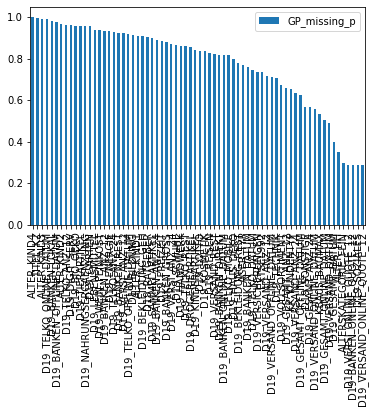

In [22]:
gp_missing_p = gp.missing_p.sort_values(ascending=False).to_frame()[:150].rename(columns = {0: 'GP_missing_p'})
gp_missing_p[:70].plot.bar()

In [23]:
#gp.missing_values(th_na_p=0.3, drop_na_columns=True)

#### Important variables o dictionary to keep

- **replace_unknown_dict**: A dictionary that needs to be used for other datasets to process

### 0.1.1 Customers

In [24]:
%%time
cust = explore(data='./dataset/Udacity_CUSTOMERS_052018.csv', debug=True)

DataFrame has shape: (191652, 369)
Wall time: 3.81 s


C:\Users\zeus\anaconda3\lib\site-packages\IPython\core\magic.py:187: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


In [25]:
# Set thresholds
cust.th_na_p=TH_NA_P
cust.th_na_col=TH_NA_COL
cust.th_high_unique=TH_HIGH_UNIQUE

In [26]:
cust.detailed_columns(drop=False)
cust.columns_stats()
cust.encode_numerical_to_float()
#cust.columns_stats()
cust.encode_na(dict_encoder=replace_unknown_dict)
cust.encode_categorical_numbers(convert_inplace=True)
cust.missing_values(th_na_p=0.3, drop_na_columns=False)

Number of columns where unique values are higher than 1000: 3
Number of columns with missinge values higher than th_na_p 0.3: 6 1.63% 
Number of rows which number of NaN columns is higher than 50: 56508 29.48%
Number of rows which all rows are NaN, from columns higher than th_na_p 0.3: 66374 34.63%
Number of numerical variables:  361
Number of discrete variables:  94
Number of continuous variables:  267
Number of categorical variables:  8
Number of columns where number of categories is higher than th_cat 45: 1
Number of columns with missinge values higher than th_na_p 0.3: 67 18.16% 
Number of rows which number of NaN columns is higher than 50: 102663 53.57%
Number of rows which all rows are NaN, from columns higher than th_na_p 0.3: 46698 24.37%


<AxesSubplot:>

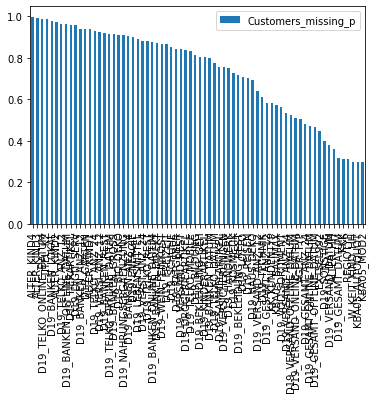

In [27]:
cust_missing_p = cust.missing_p.sort_values(ascending=False).to_frame()[:150].rename(columns = {0: 'Customers_missing_p'})
cust_missing_p[:70].plot.bar()

In [28]:
#cust.missing_values(th_na_p=0.3, drop_na_columns=True)

### 0.1.2 Mailout - Training

In [29]:
%%time
train = explore(data='./dataset/Udacity_MAILOUT_052018_TRAIN.csv', debug=True)

DataFrame has shape: (42962, 367)
Wall time: 894 ms


In [30]:
train.th_na_p=TH_NA_P
train.th_na_col=TH_NA_COL
trainth_high_unique=TH_HIGH_UNIQUE

In [31]:
train.detailed_columns(drop=False)
train.columns_stats()
train.encode_numerical_to_float()
#cust.columns_stats()
train.encode_na(dict_encoder=replace_unknown_dict)
train.encode_categorical_numbers(convert_inplace=True)
train.missing_values(th_na_p=0.3, drop_na_columns=False)

Number of columns where unique values are higher than 150: 5
Number of columns with missinge values higher than th_na_p 0.3: 6 1.63% 
Number of rows which number of NaN columns is higher than 50: 8748 20.36%
Number of rows which all rows are NaN, from columns higher than th_na_p 0.3: 13137 30.58%
Number of numerical variables:  361
Number of discrete variables:  94
Number of continuous variables:  267
Number of categorical variables:  6
Number of columns where number of categories is higher than th_cat 45: 1
Number of columns with missinge values higher than th_na_p 0.3: 64 17.44% 
Number of rows which number of NaN columns is higher than 50: 22050 51.32%
Number of rows which all rows are NaN, from columns higher than th_na_p 0.3: 7161 16.67%


<AxesSubplot:>

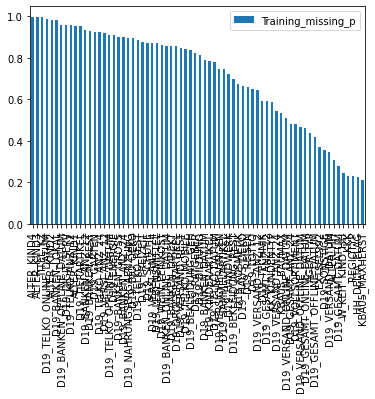

In [32]:
train_missing_p = train.missing_p.sort_values(ascending=False).to_frame()[:150].rename(columns = {0: 'Training_missing_p'})
train_missing_p[:70].plot.bar()

In [33]:
#train.missing_values(th_na_p=0.3, drop_na_columns=True)

### 0.1.3 Justifying dropping columns with high number of missings and too detailed

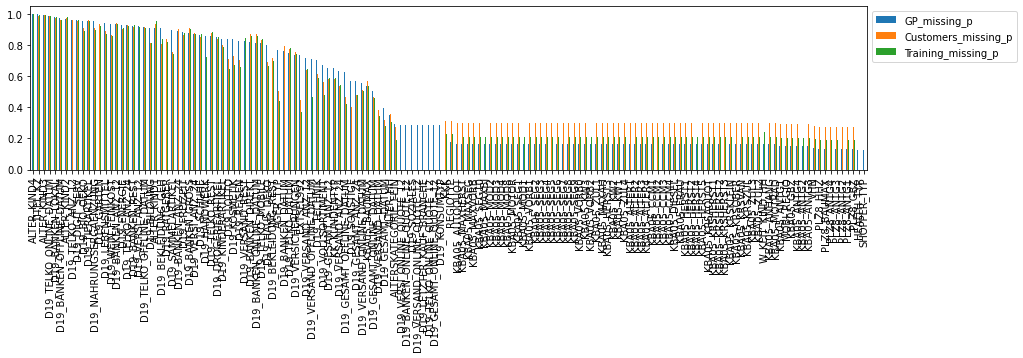

In [34]:
gp_missing_p.join(cust_missing_p, how='left').join(train_missing_p, how='left')[:150].plot.bar(figsize=(15,3)).legend(bbox_to_anchor=(1,1), loc="upper left")

I start by analyzing top missing values across the 3 main datasets, General Population from now on “GP”, Customers, and Mailout will be referred as “Training”. By limiting the top 150 features with highest percentage of missing values, we can notice immediately that there are nearly a third of them that highlight and are over 30% across the 3 datasets. I will drop these features since missing values are high across them.

### 0.1.4 Drop columns with higher number of missing values than the treshold

In [35]:
print('General Population')
gp.missing_values(th_na_p=0.3, drop_na_columns=True)
#print('Customers')
#cust.missing_values(th_na_p=0.3, drop_na_columns=True)
#print('Train Mailout')
#train.missing_values(th_na_p=0.3, drop_na_columns=True)

General Population
Number of columns with missinge values higher than th_na_p 0.3: 65 21.59% 
Number of rows which number of NaN columns is higher than 50: 153933 17.27%
Shape after dropping columns with high number of NaN: (891221, 301)


## 0.2 High unique features (hu)

I will select those features, which have more than 1000 number of unique values per feature, this will help to determine if it is a continuous value, it has many classes, or it is too detailed, that makes it unique per record.

In [36]:
gp_hu = pd.DataFrame.from_dict(gp.high_unique, orient='index').rename(columns={0:'GP'})/gp.data.shape[0]
cust_hu = pd.DataFrame.from_dict(cust.high_unique, orient='index').rename(columns={0:'Customers'})/cust.data.shape[0]
train_hu = pd.DataFrame.from_dict(train.high_unique, orient='index').rename(columns={0:'Train'})/train.data.shape[0]

In [37]:
gp_hu.join(cust_hu, how='left').join(train_hu, how='left')

,GP,Customers,Train
LNR,1.000000,1.000000,1.000000
EINGEFUEGT_AM,0.005793,0.015836,0.037242
KBA13_ANZAHL_PKW,0.001416,0.006527,0.028653


Let's explore how many unique there are in detail and what they are 

In [38]:
# List the column names
print(gp.high_unique)
# Get a sample of the columns
gp.data[gp.high_unique].sample(5)

{'LNR': 891221, 'EINGEFUEGT_AM': 5163, 'KBA13_ANZAHL_PKW': 1262}


,LNR,EINGEFUEGT_AM,KBA13_ANZAHL_PKW
200084,581196.0,1992-02-12 00:00:00,347.0
175770,762275.0,1992-02-12 00:00:00,874.0
682083,922487.0,1992-02-10 00:00:00,221.0
615121,262792.0,1992-02-10 00:00:00,417.0
534899,991679.0,2006-04-11 00:00:00,NaN


- LNR: Is unique per record, and is considered an ID of each one, will not be used for training
- EINGEFUEGT_AM: Will not consider high number of dates, more than 5k
- KBA13_ANZAHL_PKW: Related to number of cars in the PLZ8, will not be considered

I proceed to drop these

In [39]:
# Drop these columns
gp.detailed_columns(drop=True)

Number of columns where unique values are higher than 1000: 3
Data shape after droping high detailed columns: (891221, 298)


## 0.3 Outliers

### 0.3.0 General Population

I will keep using as a reference the General Population so it can be compared to the Customer's dataset. Let's see how the variables are distributed after the dropings of missing and high number of unique values

In [40]:
gp.columns_dtypes()

Number of numerical variables:  294
Number of discrete variables:  0
Number of continuous variables:  294
Number of categorical variables:  4
Number of columns where number of categories is higher than th_cat 45: 0


To get a better view of the outliers, I will first replace categorical variables into numeric, to get a good visualization of the distribution

In [41]:
# Create dictionary to encode categorical
gp.dict_categorical()
# Encode categorical
gp.replace_categorical()

Start using categorical as numerical

In [42]:
gp.columns_dtypes()

Number of numerical variables:  298
Number of discrete variables:  4
Number of continuous variables:  294
Number of categorical variables:  0
Number of columns where number of categories is higher than th_cat 45: 0


I set a new thershold for unique values, higher than 15, I consider that if it has less than 15 categories for a dataset of this size, then we have a fair number of categories for the feature. In the other hand if it has more than 15, it is worth exploring each of them.

In [43]:
gp.detailed_columns(th_high_unique=15)

Number of columns where unique values are higher than 15: 14


I got 14 features that have more than 15 unique values, let's see how many unique values each of them has and their distribution

In [44]:
gp_high_unique = pd.DataFrame.from_dict(gp.high_unique, orient='index').rename(columns={0: 'unique_values'}).sort_values(by='unique_values', ascending=False)
gp_high_unique

,unique_values
ANZ_HAUSHALTE_AKTIV,293
ANZ_STATISTISCHE_HAUSHALTE,269
GEBURTSJAHR,117
VERDICHTUNGSRAUM,47
CAMEO_DEU_2015,44
CAMEO_INTL_2015,43
LP_LEBENSPHASE_FEIN,42
EINGEZOGENAM_HH_JAHR,38
D19_LETZTER_KAUF_BRANCHE,35
MIN_GEBAEUDEJAHR,33


I will visually inspect their distribution, to find possible outliers and take actions.

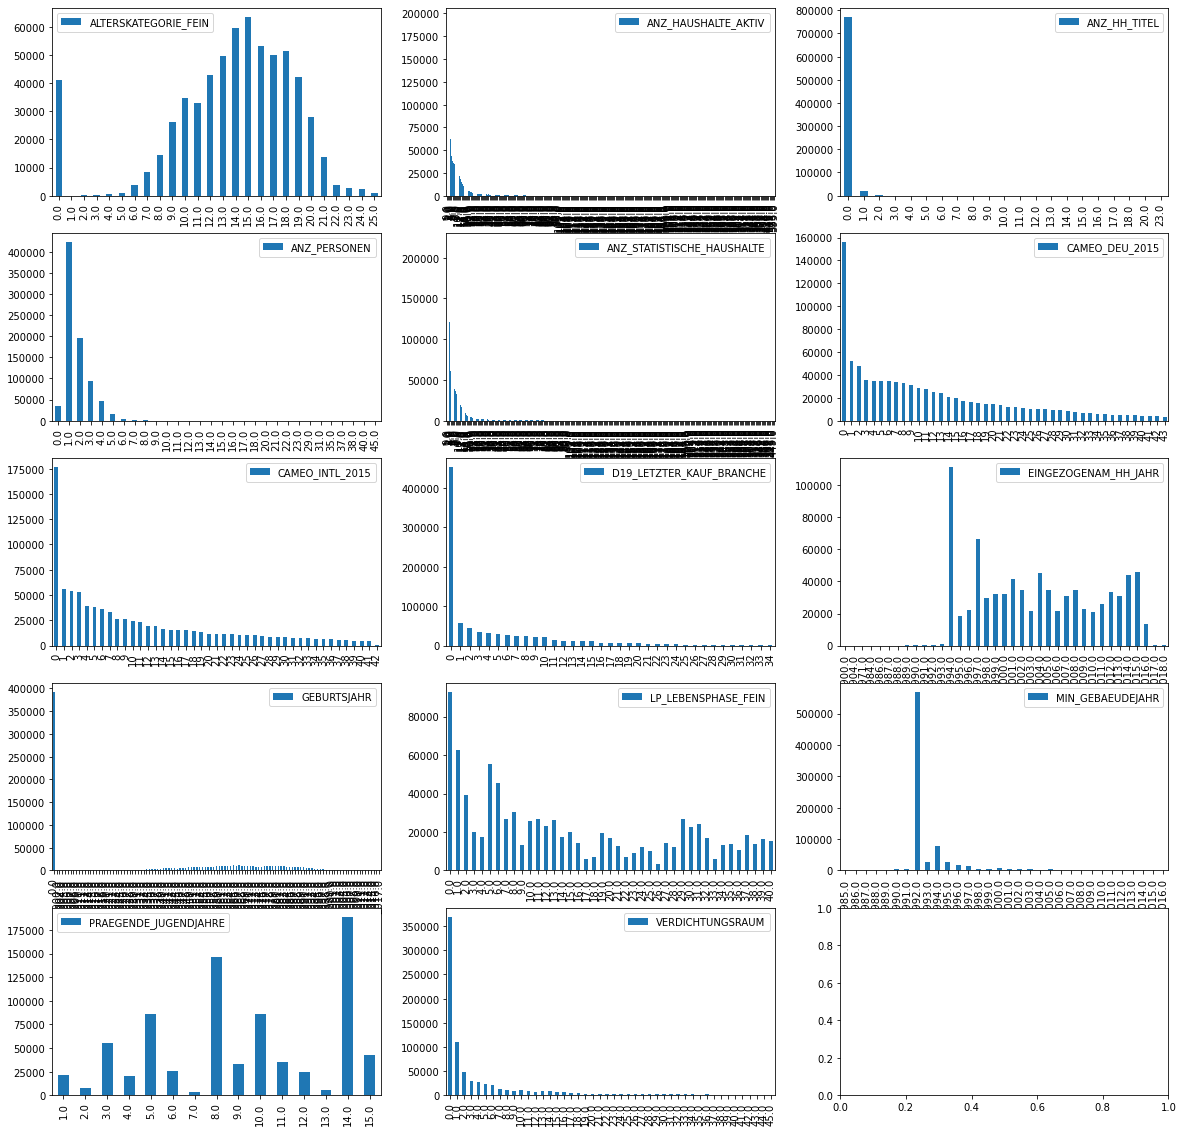

In [45]:
# Figure params
fig_x = 3
fig_y = 5
fig, ax = plt.subplots(fig_y,fig_x)
fig.set_size_inches(15,30)
y_char_id = -1

for i, col in enumerate(gp_high_unique['unique_values'].sort_index().index.values.tolist()):
    if(i%fig_x==0):
        y_char_id = y_char_id+1
    gp.data[col].value_counts().to_frame().sort_index().\
        plot.bar(ax=ax[y_char_id][i%fig_x], figsize=(20,20))

In [46]:
gp_high_unique['unique_values'].sort_index().index.values

array(['ALTERSKATEGORIE_FEIN', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'ANZ_PERSONEN', 'ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_DEU_2015',
       'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE',
       'EINGEZOGENAM_HH_JAHR', 'GEBURTSJAHR', 'LP_LEBENSPHASE_FEIN',
       'MIN_GEBAEUDEJAHR', 'PRAEGENDE_JUGENDJAHRE', 'VERDICHTUNGSRAUM'],
      dtype=object)

Then, Will apply outlier replacer by max to:
- ANZ_HAUSHALTE_AKTIV: Number of people, if too high, aprox to max allowed in outliers.
- ANZ_PERSONEN: Same criteria being adult persons in the household.
- ANZ_STATISTISCHE_HAUSHALTE: Because of distribution will apply the max rule.

And outlier replacer by median to:
- ALTERSKATEGORIE_FEIN: It is related to age classification, it is a fair number of 0s which may be NaNs, and be considered as outliers.

Will drop:
- ANZ_HH_TITEL. Too unbalanced, attributes say it should be from 1-10
- GEBURTSJAHR: Is a birthday year, and distribution is similar to unbalanced, I will not consider this.

Pass:
- CAMEO_INTL_2015: Not enough information the attribute descriptions.
- CAMEO_DEU_2015: Detailed information about environment
- D19_LETZTER_KAUF_BRANCHE: Purchase Sector related, pass.
- EINGEZOGENAM_HH_JAHR: Has a fair distribution and is related to a year number, will not apply outliers.
- LP_LEBENSPHASE_FEIN: Has a fair distribution, will not apply outliers function.
- MIN_GEBAEUDEJAHR: Will not apply outliers function. Year related.
- PRAEGENDE_JUGENDJAHRE: Will not apply outlier function, has a fair distribution. Dominating movement in the person's youth.
- VERDICHTUNGSRAUM: Not enough information.

Let's translate that criteria into a dictionary that will be applied consistenly to the dataset

In [47]:
dict_criteria = {
    'ANZ_HAUSHALTE_AKTIV': 'max',
    'ANZ_PERSONEN': 'max',
    'ANZ_STATISTISCHE_HAUSHALTE': 'max',
    'ALTERSKATEGORIE_FEIN': 'median',
}
rem_cols = ['ANZ_HH_TITEL', 'GEBURTSJAHR']

Find outliers which are outside the standard deviation of 2.33 or nearly 98% of the data.

In [48]:
gp.find_outliers(z_th=2.33)

Number of Features matching same outliers percentage records: 3
	Number of unique outliers records: 58
	Number of records repeated on all 3 features: 58
	Percentag of the records with outliers vs total: 6.507925643583354e-05
	Columns: ['KBA13_KRSHERST_AUDI_VW', 'KBA13_KRSHERST_BMW_BENZ', 'KBA13_KRSHERST_FORD_OPEL'] 

Column: ['D19_BANKEN_ONLINE_QUOTE_12']
	Number of unique outliers records: 44518
	Percentag of the records with outliers vs total: 0.049951695482938575 

Column: ['PLZ8_ANTG2']
	Number of unique outliers records: 7438
	Percentag of the records with outliers vs total: 0.008345853609822929 

Column: ['KBA13_HHZ']
	Number of unique outliers records: 13110
	Percentag of the records with outliers vs total: 0.01471015606678927 

Column: ['KBA05_SEG8']
	Number of unique outliers records: 45253
	Percentag of the records with outliers vs total: 0.05077640674984095 

Column: ['KBA13_KRSAQUOT']
	Number of unique outliers records: 60
	Percentag of the records with outliers vs total: 6

Create a dictionarly without considering these outliers, where the mean, std and median is logged per feature.

In [49]:
gp.z_dict_replacer(z_th=2.33)

Finally replace the outliers with the dictionary criteria created before

In [50]:
gp.replace_outliers(dict_criteria = dict_criteria, th_std=2.33)

Preview one of the replace conditions result.

<AxesSubplot:>

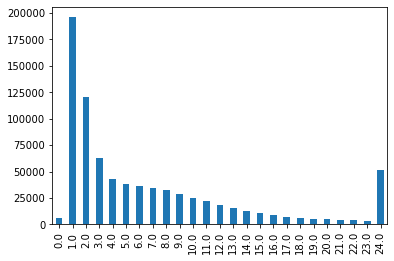

In [51]:
gp.data['ANZ_HAUSHALTE_AKTIV'].value_counts().sort_index().plot.bar()

As expected, features higher than 2.3 std, will be replaced with ceil 2.3d std value 

In [52]:
gp.replace_NA()

In [53]:
gp.remove_non_variant_columns()

In [54]:
gp.remove_columns(rem_cols)

In [55]:
# Verify there are non nulls
[var for var in gp.data.columns if gp.data[var].isnull().sum() > 0]

[]

In [56]:
features = gp.data.columns.to_list()
len(features)

296

Finally I get a clean and normalized dataset

In [57]:
gp.data[features].head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ONLINE_QUOTE_12,D19_BUCH_CD,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_LETZTER_KAUF_BRANCHE,D19_SOZIALES,D19_TELKO_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO

### 0.3.1 Customer data

Apply the same rules

Import encoders from general population into customers dataset

In [58]:
cust.dict_categorical_encoder = gp.dict_categorical_encoder
cust.dict_numerical = gp.dict_numerical

In [59]:
cust.replace_categorical()

In [60]:
cust.replace_outliers(dict_criteria = dict_criteria)

In [61]:
cust.replace_NA()

In [62]:
# Verify there are non nulls
[var for var in cust.data[features].columns if cust.data[var].isnull().sum() > 0]

[]

In [63]:
cust.data[features].head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ONLINE_QUOTE_12,D19_BUCH_CD,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_LETZTER_KAUF_BRANCHE,D19_SOZIALES,D19_TELKO_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO

### 0.3.2 Train Mailout data

Apply the same rules

Import encoders from general population into customers dataset

In [64]:
train.dict_categorical_encoder = gp.dict_categorical_encoder
train.dict_numerical = gp.dict_numerical

In [65]:
train.replace_categorical()

In [66]:
train.replace_outliers(dict_criteria = dict_criteria)

In [67]:
train.replace_NA()

In [68]:
# Verify there are non nulls
[var for var in train.data[features].columns if train.data[var].isnull().sum() > 0]

[]

In [69]:
train.data[features].head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ONLINE_QUOTE_12,D19_BUCH_CD,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_LETZTER_KAUF_BRANCHE,D19_SOZIALES,D19_TELKO_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [70]:
#https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

## 1.0 Scaling

### 1.0.0 General Population and estimator Train

In [71]:
# scale numerical features into a normalized range, 0-1
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#scaler=MinMaxScaler()
scaler=StandardScaler()

In [72]:
# store them in this dataframe
gp_scaled=pd.DataFrame(scaler.fit_transform(gp.data[features].astype(float)))

# get same features and State-County indices
gp_scaled.columns=gp.data[features].columns
gp_scaled.index=gp.data[features].index

gp_scaled.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ONLINE_QUOTE_12,D19_BUCH_CD,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_LETZTER_KAUF_BRANCHE,D19_SOZIALES,D19_TELKO_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO

### 1.0.1 Scale Customers data

In [73]:
# store them in this dataframe
cust_scaled=pd.DataFrame(scaler.transform(cust.data[features].astype(float)))

# get same features and State-County indices
cust_scaled.columns=cust.data[features].columns
cust_scaled.index=cust.data[features].index

cust_scaled.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ONLINE_QUOTE_12,D19_BUCH_CD,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_LETZTER_KAUF_BRANCHE,D19_SOZIALES,D19_TELKO_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO

## 1.2 PCA Model

### 1.2.0 General Population and estimator Train

In [74]:
from sklearn.decomposition import PCA

In [75]:
N_COMPONENTS = gp_scaled.shape[1]-1
pca = PCA(n_components=N_COMPONENTS, svd_solver='full')

In [76]:
pca.fit(gp_scaled)

PCA(n_components=295, svd_solver='full')

In [77]:
# Get Variance information from fitted model
s = pd.DataFrame(pca.explained_variance_)
sr = pd.DataFrame(pca.explained_variance_ratio_)

In [78]:
# looking at top 5 components
n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components  # 33-n

# print a selection of s
print(s.iloc[:n_principal_components, :])

           0
0  26.454318
1  17.330197
2  14.090443
3   9.189711
4   8.034266


In [79]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components  ## 33-3 = 30, for example
    # calculate approx variance
    #exp_variance = np.square(s.iloc[:n_top_components,:]).sum()/np.square(s).sum()
    exp_variance = s.iloc[:n_top_components,:].sum()
    
    return exp_variance[0]


<AxesSubplot:>

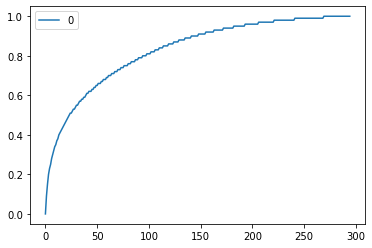

In [80]:
# calculate the explained variance
exp_variance = {i: round(explained_variance(sr,i),2) for i in range(N_COMPONENTS)}
pd.DataFrame.from_dict(exp_variance, orient='index').plot.line()

In [81]:
n_top_components = 95 # top components that explain nearly 80% of the variance

# calculate the explained variance
exp_variance = explained_variance(sr, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.7994763884646738


In [82]:
v = pd.DataFrame(pca.components_)

In [83]:
def display_component(v, features_list, component_num, n_weights=95):
    
    # get index of component (last row - component_num)
    row_idx = component_num#N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in data_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()


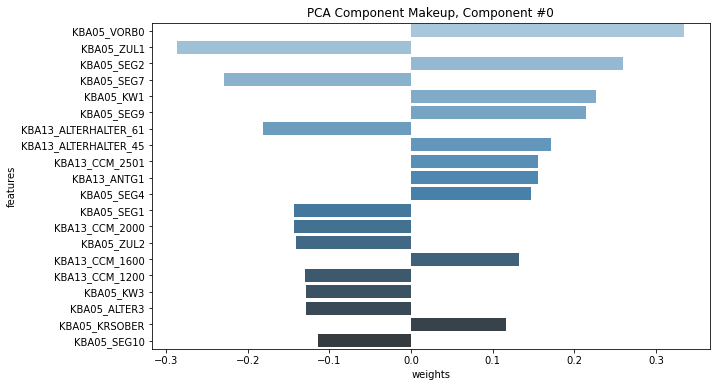

In [84]:
# Display makeup of first component
num=0
display_component(v, features, component_num=num, n_weights=20)

In [85]:
# Transform General Population to get its PCA
train_pca = pca.transform(gp_scaled)

In [86]:
# Display the first 10 Components
#train_pca[0][:10]

In [87]:
# create dimensionality-reduced data
def create_transformed_df(train_pca, data_scaled, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param data_scaled: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by record number, with n_top_component values as columns.        
     '''
    # create new dataframe based on transformed data points
    data_transformed=pd.DataFrame(train_pca)

    # index by county, just like counties_scaled
    data_transformed.index=data_scaled.index

    # keep only the top n components
    #start_idx = N_COMPONENTS - n_top_components
    data_transformed = data_transformed.iloc[:,:n_top_components]
    
    # reverse columns, component order     
    return data_transformed#.iloc[:, ::-1]
    

In [88]:
# specify top n
top_n = n_top_components

# call your function and create a new dataframe
gp_transformed = create_transformed_df(train_pca, gp_scaled, n_top_components=top_n)

# add descriptive columns
PCA_list=['c_'+str(i) for i in range(top_n)]
gp_transformed.columns=PCA_list 

# print result
gp_transformed.head()

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,c_29,c_30,c_31,c_32,c_33,c_34,c_35,c_36,c_37,c_38,c_39,c_40,c_41,c_42,c_43,c_44,c_45,c_46,c_47,c_48,c_49,c_50,c_51,c_52,c_53,c_54,c_55,c_56,c_57,c_58,c_59,c_60,c_61,c_62,c_63,c_64,c_65,c_66,c_67,c_68,c_69,c_70,c_71,c_72,c_73,c_74,c_75,c_76,c_77,c_78,c_79,c_80,c_81,c_82,c_83,c_84,c_85,c_86,c_87,c_88,c_89,c_90,c_91,c_92,c_93,c_94
0,0.394558,-0.391793,1.706234,-3.193571,1.498363,1.040751,-0.139082,1.143816,-1.582912,-1.084727,-3.720485,2.109179,0.305835,0.499148,-0.009814,0.590804,-0.269788,-1.666971,0.069975,-0.283902,0.348686,-0.020205,-0.216321,-0.138714,0.372019,0.256193,0.134237,0.198981,-0.060039,0.057846,0.211108,-0.448428,0.013256,0.696393,0.057578,0.069465,-0.737151,-0.014244,-0.234986,-0.315517,-0.902699,0.662895,0.143536,0.186298,0.294807,0.122437,-0.347827,0.663093,-0.010682,-0.003078,0.195561,-0.102263,0.299876,0.244962,-0.568872,-0.536128,-0.325824,0.054982,0.065288,0.091406,-0.178167,-0.283968,-0.052131,-0.320565,-0.196186,-0.100493,0.086987,0.172189,0.155577,0.324189,0.157124,-0.384392,0.350623,0.545433,-0.162973,0.288876,1.359735,0.262981,-0.660845,0.405510,0.072044,-0.119353,0.143917,-0.016157,-0.503136,0.330404,0.173117,0.228636,0.226001,-0.349870,-0.528216,0.553716,0.477787,-0.047308,-0.908257
1,3.981309,5.749494,-6.366510,-1.411969,0.733363,-3.603805,-4.323172,0.007133,0.556763,-0.771196,4.630573,1.208106,0.967765,-1.217656,-3.397376,0.757923,-1.188398,-3.515020,0.055180,1.141517,-0.315134,0.016390,-0.059030,2.843352,2.857991,2.098641,-2.462787,0.976142,-2.432290,-3.536622,2.061424,-0.055970,0.410233,-0.259926,0.235215,-0.468579,1.158214,-0.292433,1.363331,-1.162287,-1.155867,-0.358858,-0.441413,1.315201,2.076165,2.036520,2.221780,0.726896,-4.297526,0.553888,-0.242096,1.574979,0.432740,-1.191585,-0.446692,-0.726164,-0.145226,-0.474670,-0.911198,-2.051673,0.945307,1.199391,0.135209,2.035586,1.302560,0.893648,9.367013,2.990094,-5.081393,-0.744705,0.949316,0.918539,-0.200337,-1.399471,0.045372,-1.523738,-0.533068,0.809784,-0.232203,-0.915417,-0.103998,1.596720,-0.003059,-0.430918,-0.260878,0.229752,-1.281331,-0.293074,0.892026,-0.488655,-0.154931,1.587853,1.854398,1.829281,1.615720
2,-0.749857,2.693276,-1.551019,-1.261464,5.946766,5.026409,1.332002,-2.431088,2.641435,0.861243,1.004384,-2.731438,-1.974677,0.421529,0.445083,1.433154,1.138749,0.409605,-2.731179,1.510210,-0.325061,-1.025990,-1.823972,1.020587,0.544948,1.060809,1.617592,1.625367,1.654756,-0.218405,-0.169459,0.155363,1.369558,-1.067691,-1.963534,-0.372715,0.353338,0.516074,0.820359,-1.967051,0.707110,-0.654803,0.131830,-0.512205,-1.574145,-1.193566,1.332098,-1.658772,1.092350,1.353989,0.342029,0.584101,0.322088,-0.435816,-0.886657,0.724772,0.937933,-0.028767,-1.251458,1.274791,-0.221482,-1.095583,-1.390673,-0.628683,-0.141414,0.188934,-0.066302,0.075599,-0.016163,1.300700,-0.423501,-0.393263,-1.308243,1.594450,-0.663604,1.159489,0.106685,-0.785103,-0.835735,0.244486,0.207216,-0.438793,0.442613,0.051520,1.514961,0.589357,1.140717,-0.348720,0.333385,0.934300,-1.028427,-1.301192,-0.454813,-0.682478,0.455376
3,-6.327725,0.728739,1.946597,-4.025822,0.917899,-1.357736,-1.048408,-0.727736,-2.868985,-1.399867,2.783910,-0.872859,1.297712,-0.557780,2.261116,-0.382981,2.125360,1.366182,0.213413,-0.798820,0.775514,0.233930,1.944962,-0.492157,-1.696163,1.465805,0.807389,-3.083220,0.773925,-0.695451,0.126309,-1.316208,1.055235,0.998433,-0.636792,-4.203344,0.321272,0.475700,-2.351813,0.753540,1.337064,-0.644698,-0.971872,-0.992866,0.140302,-0.286612,0.478807,-2.075327,2.424794,-0.988581,-1.818914,-2.751807,1.421701,-0.213194,-0.077151,0.537834,-1.130855,0.370893,0.217386,0.358970,1.473357,0.254659,-1.733633,0.606123,-0.752482,-0.036303,-0.099535,-0.687198,-0.329396,0.363847,-0.048189,-0.547509,1.294481,1.454743,-0.267497,0.497888,-1.576079,0.112894,-0.518682,-0.983062,0.530996,-0.926463,-0.705322,-1.096814,0.477628,-0.276004,-0.3259

In [89]:
#gp_transformed.reset_index().to_feather('gp_pca_transformed.ftr',)
#gp_transformed = pd.read_feather('gp_pca_transformed.ftr')

### 1.2.1  Customer data Transform

In [90]:
cust_pca = pca.transform(cust_scaled)

In [91]:
# specify top n
top_n = n_top_components

# call your function and create a new dataframe
cust_transformed = create_transformed_df(cust_pca, cust_scaled, n_top_components=top_n)

# add descriptive columns
PCA_list=['c_'+str(i) for i in range(top_n)]
cust_transformed.columns=PCA_list 

# print result
cust_transformed.head()

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,c_29,c_30,c_31,c_32,c_33,c_34,c_35,c_36,c_37,c_38,c_39,c_40,c_41,c_42,c_43,c_44,c_45,c_46,c_47,c_48,c_49,c_50,c_51,c_52,c_53,c_54,c_55,c_56,c_57,c_58,c_59,c_60,c_61,c_62,c_63,c_64,c_65,c_66,c_67,c_68,c_69,c_70,c_71,c_72,c_73,c_74,c_75,c_76,c_77,c_78,c_79,c_80,c_81,c_82,c_83,c_84,c_85,c_86,c_87,c_88,c_89,c_90,c_91,c_92,c_93,c_94
0,-9.871781,3.942426,4.171110,-0.841605,-1.714966,-1.736347,2.781595,0.778653,0.342850,-0.935206,0.491377,-0.176942,1.534828,-0.376775,0.039099,0.046612,-3.411896,-0.132389,-1.459480,-1.010132,2.073758,-0.037706,-0.042019,-0.832139,2.241246,-1.555631,-0.621366,-2.147830,-2.849850,1.341837,0.146875,0.395517,-0.666659,0.046334,0.413345,-1.835412,1.285805,-1.310866,1.424942,-1.419394,1.617417,0.552404,-1.651746,-1.854713,-0.147862,0.363721,1.242882,1.936854,0.350424,-1.359087,-0.457606,0.632062,-1.048206,-0.472614,1.539013,-0.590396,0.511317,0.266074,-0.915079,-0.314942,-1.307343,0.334106,0.245331,-0.151230,-2.103287,0.147579,-0.443706,-0.743248,-0.451793,-0.627123,0.331062,-1.583406,-1.133061,-0.312092,1.718114,0.395502,-0.097323,-0.526452,-0.854730,-0.235380,0.143341,-0.629575,-0.874085,0.237761,0.964697,0.426914,0.419079,0.251484,0.534743,0.751589,0.148180,0.543445,-0.074999,0.920866,-1.082096
1,-0.665768,-0.544655,1.699407,-0.251112,-0.527261,-0.771911,1.920096,0.414500,-0.227950,-0.999074,-1.766856,1.116218,0.560387,0.026359,0.418022,0.015111,-0.087897,0.045677,0.233301,0.382871,-0.348753,0.016317,0.726175,0.471340,-0.033366,0.970161,0.363779,0.487570,0.399410,0.334523,-0.494743,0.719881,-0.312086,-1.074299,-0.278190,0.455194,-0.614863,0.095147,0.315732,-0.958679,0.512019,-0.488181,-0.773041,-2.083166,-0.802070,-0.579448,1.242342,-0.433931,-0.271213,-0.657303,-0.236128,-0.654005,-0.556330,-0.499789,-0.011869,0.636265,-0.125126,-0.738197,-0.131404,0.168301,0.573546,0.703747,0.375203,0.798175,-0.232044,-0.089123,-0.291960,0.662324,0.384567,0.175943,-1.138720,-0.300794,-1.519660,-0.669886,-0.514467,0.082526,-0.653134,-1.078760,-1.298314,1.623164,0.332742,0.228110,-0.401650,0.345404,-0.634382,-1.124519,-0.452455,0.430398,0.564388,-0.148935,0.157129,0.506824,-0.120058,-0.159248,0.071403
2,0.308317,3.607836,6.365449,-2.197426,-3.376227,2.284473,-0.914125,2.853387,-6.564386,0.858715,2.466306,0.535661,0.795234,1.397981,0.079676,-2.121003,0.276561,-0.125198,0.542850,-0.439312,-1.988760,0.092425,0.307715,0.757980,-1.762482,0.599839,-1.118498,-1.985194,-0.588609,-0.042039,-1.305804,0.299319,0.076134,0.333391,1.311127,1.449303,0.297826,2.508741,-2.060483,1.375046,1.081635,-0.900665,0.552020,1.868891,2.301548,0.185914,-0.456843,-0.930571,0.398529,-1.944191,-0.690791,-0.086323,-1.162649,2.028114,-0.984717,0.344309,-0.458749,0.893350,0.010888,-1.961755,-2.307335,1.470623,0.689734,0.590385,1.586247,-0.441376,0.175514,0.230585,0.205489,1.371613,-1.092730,-0.203764,0.699769,0.587658,-0.162434,-0.000376,0.600838,0.161379,-0.116172,-0.908358,-0.737229,0.495103,-1.173601,-2.339710,-0.479875,-0.426163,0.545047,1.738209,-1.929737,0.109222,-0.051445,0.572467,1.790365,-0.690758,0.827395
3,-6.535457,-1.467866,4.526233,0.521849,3.564291,-3.656050,3.205490,-3.007357,-0.706598,-0.729179,-1.221062,-2.691860,0.303660,2.472146,1.801232,1.846189,-1.274022,0.907130,-0.305979,-1.449596,-1.001500,-1.429469,-2.837071,1.658102,-2.061672,-1.555622,0.538185,1.185483,0.530725,0.920283,-1.536566,-1.897320,3.148954,-0.299620,-0.121395,-2.289857,-0.298247,1.245461,-1.904784,3.482365,-1.285391,1.742397,0.640998,-2.487655,-0.064360,0.189117,0.432606,-0.571772,0.359074,0.321912,0.356867,-0.125684,-0.768956,0.580955,-0.439947,0.775485,2.116863,-0.344819,-0.896070,-0.704901,0.903592,0.542644,-0.635337,-0.215227,1.420324,-1.380757,0.487301,1.064521,1.181946,-0.663073,-1.252279,-0.742852,2.898654,1.267071,0.195852,-0.591214,-0.336429,-0.447951,-2.124839,0.528106,0.468288,0.748153,1.719815,-0.696282,0.902153,0.103706,1

In [92]:
#cust_transformed.reset_index().to_feather('cust_pca_transformed.ftr',)
#cust_transformed = pd.read_feather('cust_pca_transformed.ftr')

## 1.3 KMeans CPU

### 1.3.0 General Population and estimator Train

In [93]:
# Retrieved transformed datasets GP and Customers to PCA Level
#gp_transformed = pd.read_feather('gp_pca_transformed.ftr')
#cust_transformed = pd.read_feather('cust_pca_transformed.ftr')

In [94]:
from sklearn.cluster import KMeans

Now I will run a KMeans cluster for a range of centroids, in order to visualize how close the samples are to their closest cluster center, and be able to select the number of clusters for this use case.

..................................

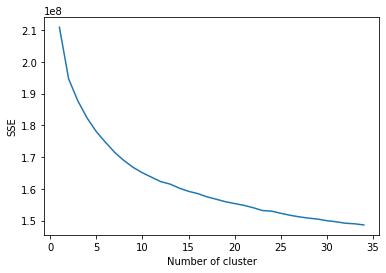

Wall time: 1h 24min 1s


In [96]:
%%time
sse = {}
for k in range(1, 35):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(gp_transformed)
    print('.', end='')
    #data_transformed["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [97]:
{x+1:round((sse[x]-sse[x+1])/1000,0) for x in range(1,len(sse))}

{2: 16280.0,
 3: 6929.0,
 4: 5398.0,
 5: 4282.0,
 6: 3393.0,
 7: 3172.0,
 8: 2563.0,
 9: 2154.0,
 10: 1692.0,
 11: 1404.0,
 12: 1389.0,
 13: 765.0,
 14: 1290.0,
 15: 994.0,
 16: 718.0,
 17: 1018.0,
 18: 751.0,
 19: 788.0,
 20: 578.0,
 21: 563.0,
 22: 737.0,
 23: 889.0,
 24: 197.0,
 25: 682.0,
 26: 620.0,
 27: 498.0,
 28: 405.0,
 29: 302.0,
 30: 511.0,
 31: 337.0,
 32: 450.0,
 33: 189.0,
 34: 350.0}

In [95]:
N_CLUSTERS = 10

In [96]:
%%time
kmeans = KMeans(n_clusters=N_CLUSTERS, max_iter=1000).fit(gp_transformed)

Wall time: 1min 8s


In [97]:
gp_kmeans = kmeans.predict(gp_transformed)

<AxesSubplot:>

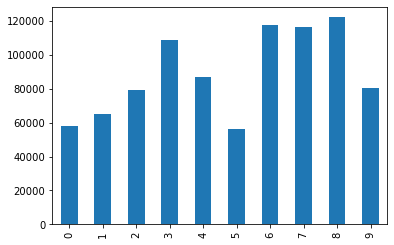

In [98]:
pd.Series(gp_kmeans).value_counts().sort_index().plot.bar()

<AxesSubplot:>

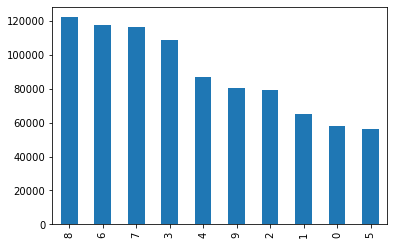

In [99]:
pd.Series(gp_kmeans).value_counts().plot.bar()

The submitted report, contains the kmeans estimator that makes the following cluster. Since Kmeans randomizes the original centroid, and then repeats 10 times to get the best in terms of inertia, is hard to reproduce the exact kmeans estimator. For reporting purposes I don't delete it from Workbook.

<AxesSubplot:>

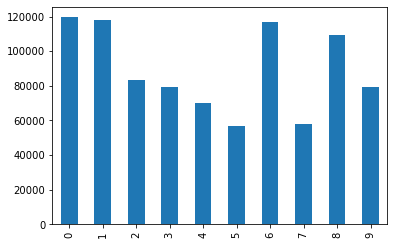

In [11]:
pd.Series(gp_kmeans).value_counts().sort_index().plot.bar()

<AxesSubplot:>

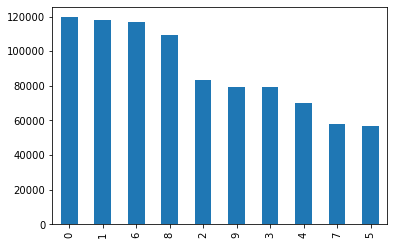

In [12]:
pd.Series(gp_kmeans).value_counts().plot.bar()

Even when the number of clusters from submission to a new run, is different, when sorting them from highest to lowest, we appreciate a very similar plot.

### 1.3.1 Customer data Predict Kmeans

In [100]:
cust_kmeans = kmeans.predict(cust_transformed)

<AxesSubplot:>

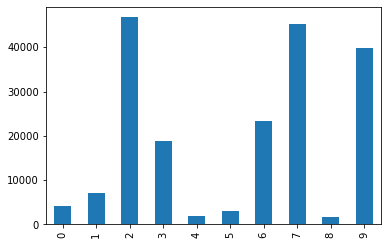

In [101]:
pd.Series(cust_kmeans).value_counts().sort_index().plot.bar()

<AxesSubplot:>

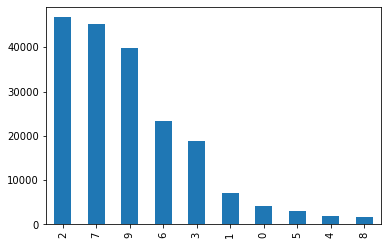

In [102]:
pd.Series(cust_kmeans).value_counts().plot.bar()

Similarly to General Population, the following is the clustering submited by the estimator.

<AxesSubplot:>

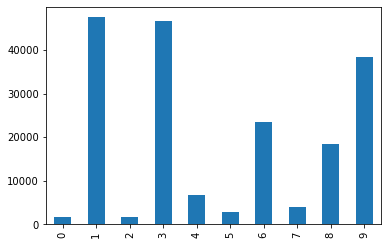

In [13]:
pd.Series(cust_kmeans).value_counts().sort_index().plot.bar()

<AxesSubplot:>

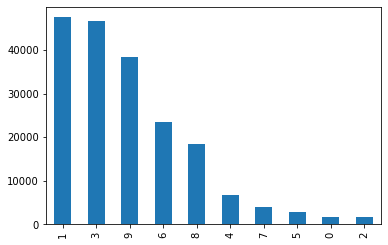

In [14]:
pd.Series(cust_kmeans).value_counts().plot.bar()

### 1.3.2 Save models

In [105]:
#models_clustering = (scaler ,pca, kmeans)

In [106]:
#pickle.dump(models_clustering, open('trained_models/models_clustering.pkl', 'wb'))

## 1.4 Customer Segmentation by Kmeans

### 1.4.0 Load Trained Models and Transform Datasets

In [23]:
from preprocess.exploring import explore, nan_encoder
from config import config
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

Parameters of the normalazied datasets were registered and saved into a config file, in order to make it reproducible and guarantee datasets will have the same criteria for normalizing, they are retrieved under the normalize() Method.

I saved the trained models so I can make transformations and predictions on already trained datasets or new ones.

In [6]:
scaler, pca, kmeans = pickle.load(open('trained_models/models_clustering.pkl', 'rb'))

Let's load the raw dataset and normalize and transform it with parameters and models from previous sections.

In [7]:
%%time
# General Population
gp_normalized = explore(data='./dataset/Udacity_AZDIAS_052018.csv', debug=True).normalize().data.astype(float)
gp_kmeans = kmeans.predict(pca.transform(scaler.transform(gp_normalized))[:,:95])

C:\Users\zeus\anaconda3\lib\site-packages\IPython\core\magic.py:187: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


DataFrame has shape: (891221, 366)
Start Normalizing
Number of columns with missinge values higher than th_na_p 0.3: 6 1.64% 
Number of rows which number of NaN columns is higher than 50: 139890 15.7%
Number of rows which all rows are NaN, from columns higher than th_na_p 0.3: 460146 51.63%
Number of numerical variables:  360
Number of discrete variables:  93
Number of continuous variables:  267
Number of categorical variables:  6
Number of columns where number of categories is higher than th_cat 45: 1
1 - Done encoding Numerical to Float
2 - Done encoding NaNs by catalog
3 - Done encoding categorical numbers to Float
4 - Done encoding categorical strings to Numbers
5 - Done replacing Outliers
6 - Done validating no NaNs
End Normalizing
Final data shape: (891221, 296)
Wall time: 1min


In [8]:
%%time
# Customers
cust_groups = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
cust_normalized = explore(data='./dataset/Udacity_CUSTOMERS_052018.csv', debug=True).normalize(keep_cols = cust_groups).data
cust_transformed = pca.transform(scaler.transform(cust_normalized[config.FEATURES].astype(float)))[:,:95]
cust_kmeans = kmeans.predict(cust_transformed)

C:\Users\zeus\anaconda3\lib\site-packages\IPython\core\magic.py:187: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


DataFrame has shape: (191652, 369)
Start Normalizing
Number of columns with missinge values higher than th_na_p 0.3: 6 1.63% 
Number of rows which number of NaN columns is higher than 50: 56508 29.48%
Number of rows which all rows are NaN, from columns higher than th_na_p 0.3: 66374 34.63%
Number of numerical variables:  361
Number of discrete variables:  94
Number of continuous variables:  267
Number of categorical variables:  8
Number of columns where number of categories is higher than th_cat 45: 1
1 - Done encoding Numerical to Float
2 - Done encoding NaNs by catalog
3 - Done encoding categorical numbers to Float
4 - Done encoding categorical strings to Numbers
5 - Done replacing Outliers
6 - Done validating no NaNs
End Normalizing
Final data shape: (191652, 299)
Wall time: 14.1 s


### 1.4.1 Customers Segments distribution compared to General Population

In [9]:
# Create series of distribution of cluster among GP and Customers
gp_distribution = pd.Series(gp_kmeans).value_counts()
cust_distribution = pd.Series(cust_kmeans).value_counts()

Additionally, the customer profile is based on the customer groups described as additional columns in the Customer dataset

In [10]:
cust_profile = cust_normalized[cust_groups].copy()
cust_profile['GROUP'] = cust_kmeans
cust_profile.head()

,CUSTOMER_GROUP,ONLINE_PURCHASE,PRODUCT_GROUP,GROUP
0,MULTI_BUYER,0.0,COSMETIC_AND_FOOD,1
1,SINGLE_BUYER,0.0,FOOD,6
2,MULTI_BUYER,0.0,COSMETIC_AND_FOOD,6
3,MULTI_BUYER,0.0,COSMETIC,1
4,MULTI_BUYER,0.0,FOOD,6


Calculate the percentage distribution of each of the previous categories, in the different clusters/groups

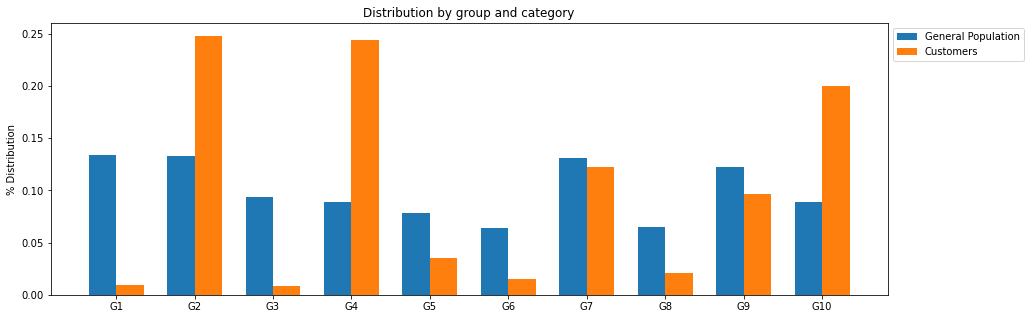

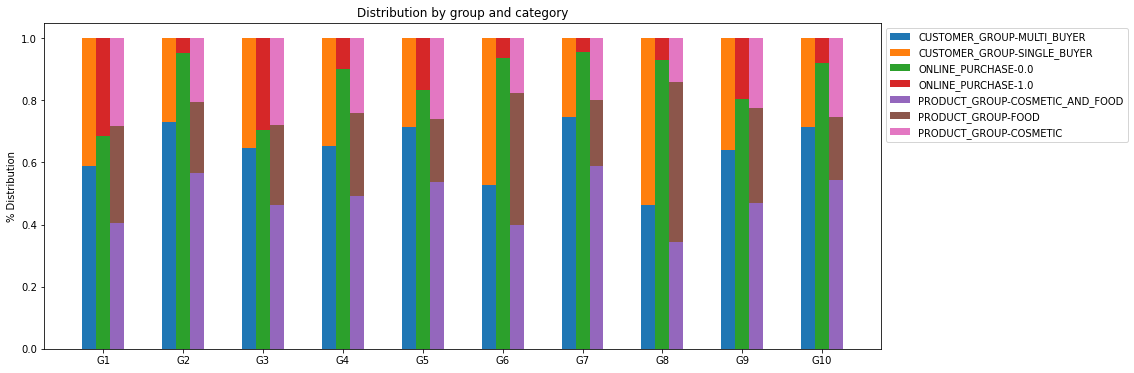

In [15]:
labels = ['G'+str(i) for i in range(1,config.N_CLUSTERS+1)]
gp_means = gp_distribution.sort_index().values/gp_distribution.sum()
cust_means = cust_distribution.sort_index().values/cust_distribution.sum()
total_by_group = cust_profile['GROUP'].value_counts().sort_index().values

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

n_1 = 2
pos_bar_idx_1 = []
for i in [width*(x+0)/(n_1-1) for x in range(n_1)]:
    pos_bar_idx_1.append(i)
n_2 = 3
pos_bar_idx_2 = []
for i in [width*(x+0)/(n_2-1) for x in range(n_2)]:
    pos_bar_idx_2.append(i)    
    
x_1 = x - width/2
x_2 = x - width/2
fig, ax = plt.subplots(figsize=(15,5))
fig2, ax2 = plt.subplots(figsize=(15,6))

rects1 = ax.bar(x_1 + pos_bar_idx_1[0], gp_means, width/(n_1-1), label='General Population')
rects2 = ax.bar(x_1 + pos_bar_idx_1[1], cust_means, width/(n_1-1), label='Customers')

c = []
for i, group in enumerate(cust_groups):
    unique_vals = cust_profile[group].unique().tolist()
    g_dist = cust_profile.reset_index().groupby(['GROUP',group])['index'].count()\
                    .unstack(group).div(total_by_group, axis=0)
    bot=np.zeros(config.N_CLUSTERS)
    for unique in unique_vals:
        label=f"{group}-{unique}"
        y_vals = g_dist[unique].values#*cust_means
        c.append(ax2.bar(x_2+pos_bar_idx_2[i] , y_vals, width/(n_2-1), label=label, bottom=bot)) #kind='bar', stacked=True
        bot=bot+y_vals
    #print(g_dist.to_markdown())

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% Distribution')
ax.set_title('Distribution by group and category')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1,1), loc="upper left")

ax2.set_ylabel('% Distribution')
ax2.set_title('Distribution by group and category')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend(bbox_to_anchor=(1,1), loc="upper left")

plt.show()

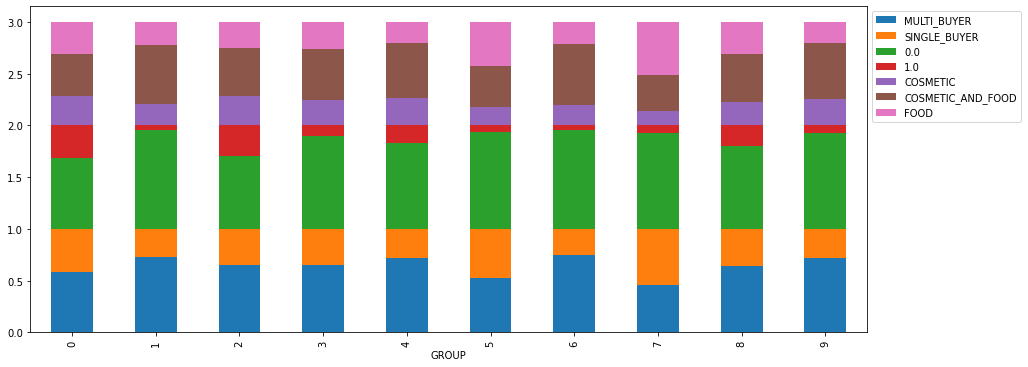

In [16]:
g_cust = cust_profile.reset_index().groupby(['GROUP','CUSTOMER_GROUP'])['index'].count()\
        .unstack('CUSTOMER_GROUP').div(total_by_group, axis=0)#.plot(kind='bar', stacked=True)
g_purc = cust_profile.reset_index().groupby(['GROUP','ONLINE_PURCHASE'])['index'].count()\
        .unstack('ONLINE_PURCHASE').div(total_by_group, axis=0)#.plot(kind='bar', stacked=True)
g_prod = cust_profile.reset_index().groupby(['GROUP','PRODUCT_GROUP'])['index'].count()\
        .unstack('PRODUCT_GROUP').div(total_by_group, axis=0)#.plot(kind='bar', stacked=True)
g_cust.merge(g_purc, how='left', left_index=True, right_index=True)\
        .merge(g_prod, how='left', left_index=True, right_index=True).plot(kind='bar', stacked=True, figsize=(15,6))\
        .legend(bbox_to_anchor=(1,1), loc="upper left")

Good distribution for General Population and noticeable groups/cluster that are more represented by customers

### 1.4.1 Principal Features that describe Clusters where Customers are highly represented

In [17]:
cust_df = cust_normalized.copy()

In [18]:
cust_df['km'] = cust_kmeans

In [19]:
def disp_c(v, features_list, component_num, n_weights=95):
    
    # get index of component (last row - component_num)
    row_idx = component_num#N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[row_idx, :]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in data_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()
    
    return sorted_weight_data[['abs_weights','features']]


In [20]:
group_categories = {}
total_by_group=cust_profile['GROUP'].value_counts().sort_index().values
for gr in cust_groups:
    unique_vals = cust_profile[gr].unique().tolist()
    grouping_df = cust_profile.groupby([gr,'GROUP']).count().reset_index()
    #print(grouping_df.to_markdown())
    for cat in unique_vals:
        group_cat_df = grouping_df.loc[grouping_df[gr]==cat].iloc[:,3].sort_index().values
        group_categories[str(gr)+'-'+str(cat)]= group_cat_df/total_by_group#group_cat_df.sum()#cust_normalized.shape[0]
    print(gr, cat)

CUSTOMER_GROUP SINGLE_BUYER
ONLINE_PURCHASE 1.0
PRODUCT_GROUP COSMETIC


In [21]:
knn={}
for cluster in range(config.N_CLUSTERS):
    knn[cluster] = cust_df.loc[cust_df['km']==cluster,'km'].index.to_list()
print(len(knn))

10


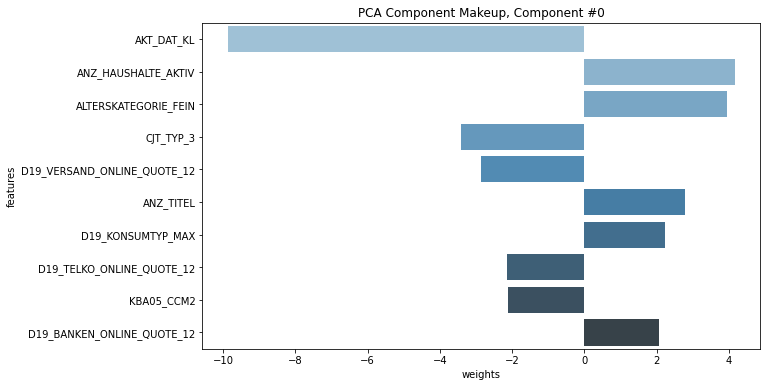

In [24]:
# For Visualizing per Group/Cluster, components that best describe them.
for row in knn[1][:1]:
    disp_c(pd.DataFrame(cust_transformed), config.FEATURES, component_num=row, n_weights=10)

Define which clusters will represent the customers

In [25]:
# Define a treshold to select cluster that are more represented by customers
#  this is a % of customers in a cluster
th_top_group = 0.1
top_cust_groups = pd.DataFrame(cust_means).loc[cust_means>th_top_group].index.values.tolist()

I use as a catalog, the csv attributes I built from the csvs provided, to retrieve their descriptions, values and meanings

In [26]:
attributes = pd.read_csv('attributes2.csv', sep='|')

Let's plot the top features per cluster, and give a description and meaning of their highest features values

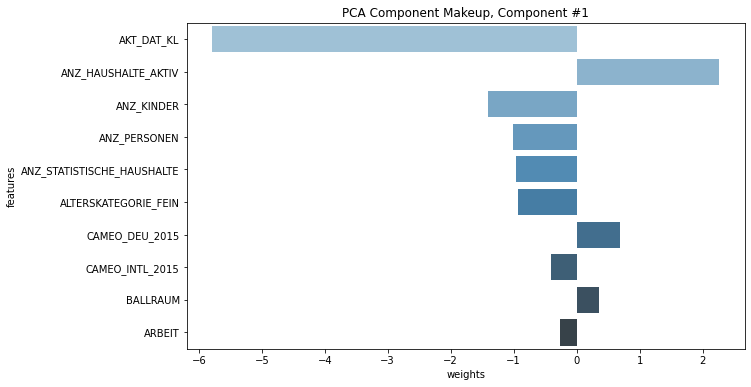

AKT_DAT_KL 1 : No Match
ANZ_HAUSHALTE_AKTIV 1 : number of households in the building
ANZ_KINDER 0 : No Match
ANZ_PERSONEN 2 : number of adult persons in the household
ANZ_STATISTISCHE_HAUSHALTE 1 : No Match
ALTERSKATEGORIE_FEIN 10 : No Match
CAMEO_DEU_2015 8 : CAMEO classification 2015 - detailled classification Family Starter
CAMEO_INTL_2015 3 : (each German CAMEO code belongs to one international code) Prosperous Households-Older Families & Mature Couples
BALLRAUM 6 : distance to next urban centre  50-100 km
ARBEIT 2 : No Match
KKK 3 : purchasing power average
MOBI_REGIO 5 : moving patterns very low mobility 
ANREDE_KZ 1 : gender male
HH_EINKOMMEN_SCORE 4 : estimated household net income  average income
CJT_GESAMTTYP 2 : customer journey typology Advertising- and Consumptiontraditionalist
EWDICHTE 2 : density of inhabitants per square kilometer 34 - 89 HH/km²
HEALTH_TYP 2 : health typology sanitary affine  
SHOPPER_TYP 3 : shopping typology demanding shopper


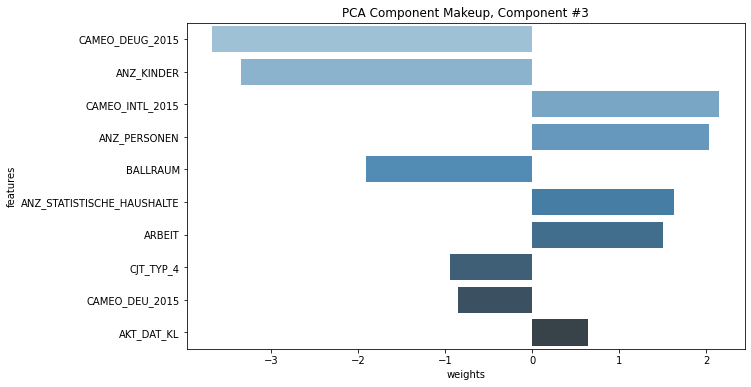

CAMEO_DEUG_2015 6 : CAMEO classification 2015 - Uppergroup low-consumption middleclass
ANZ_KINDER 0 : No Match
CAMEO_INTL_2015 0 : (each German CAMEO code belongs to one international code) Poorer Households-Pre-Family Couples & Singles
ANZ_PERSONEN 1 : number of adult persons in the household
BALLRAUM 5 : distance to next urban centre  40 - 50 km
ANZ_STATISTISCHE_HAUSHALTE 3 : No Match
ARBEIT 3 : No Match
CJT_TYP_4 5 : No Match
CAMEO_DEU_2015 0 : CAMEO classification 2015 - detailled classification Petty Bourgeois
AKT_DAT_KL 3 : No Match
KKK 3 : purchasing power average
MOBI_REGIO 3 : moving patterns middle mobility
ANREDE_KZ 2 : gender female
HH_EINKOMMEN_SCORE 2 : estimated household net income  very high income
CJT_GESAMTTYP 6 : customer journey typology Advertising-Enthusiast with restricted Cross-Channel-Behaviour 
EWDICHTE 4 : density of inhabitants per square kilometer 150 - 319 HH/km²
HEALTH_TYP 2 : health typology sanitary affine  
SHOPPER_TYP 2 : shopping typology family-sho

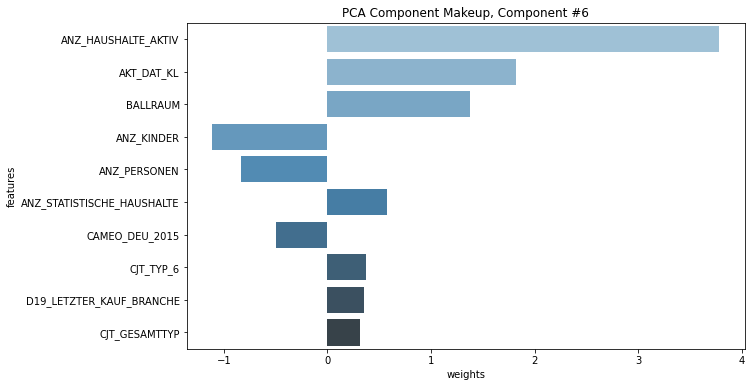

ANZ_HAUSHALTE_AKTIV 4 : number of households in the building
AKT_DAT_KL 1 : No Match
BALLRAUM 6 : distance to next urban centre  50-100 km
ANZ_KINDER 0 : No Match
ANZ_PERSONEN 1 : number of adult persons in the household
ANZ_STATISTISCHE_HAUSHALTE 1 : No Match
CAMEO_DEU_2015 0 : CAMEO classification 2015 - detailled classification Petty Bourgeois
CJT_TYP_6 5 : No Match
D19_LETZTER_KAUF_BRANCHE 0 : No Match
CJT_GESAMTTYP 2 : customer journey typology Advertising- and Consumptiontraditionalist
KKK 3 : purchasing power average
MOBI_REGIO 3 : moving patterns middle mobility
ANREDE_KZ 1 : gender male
HH_EINKOMMEN_SCORE 5 : estimated household net income  lower income
CJT_GESAMTTYP 2 : customer journey typology Advertising- and Consumptiontraditionalist
EWDICHTE 5 : density of inhabitants per square kilometer 320 - 999 HH/km²
HEALTH_TYP 2 : health typology sanitary affine  
SHOPPER_TYP 3 : shopping typology demanding shopper


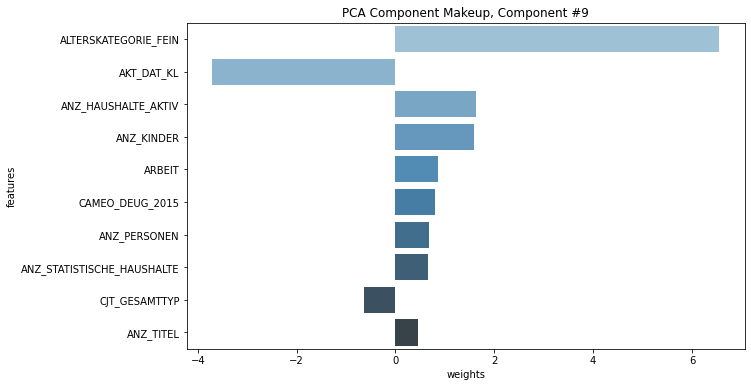

ALTERSKATEGORIE_FEIN 15 : No Match
AKT_DAT_KL 1 : No Match
ANZ_HAUSHALTE_AKTIV 1 : number of households in the building
ANZ_KINDER 0 : No Match
ARBEIT 3 : No Match
CAMEO_DEUG_2015 1 : CAMEO classification 2015 - Uppergroup upper class
ANZ_PERSONEN 2 : number of adult persons in the household
ANZ_STATISTISCHE_HAUSHALTE 1 : No Match
CJT_GESAMTTYP 2 : customer journey typology Advertising- and Consumptiontraditionalist
ANZ_TITEL 0 : number of professional title holder in household 
KKK 1 : purchasing power very high
MOBI_REGIO 4 : moving patterns low mobility
ANREDE_KZ 1 : gender male
HH_EINKOMMEN_SCORE 1 : estimated household net income  highest income
CJT_GESAMTTYP 2 : customer journey typology Advertising- and Consumptiontraditionalist
EWDICHTE 5 : density of inhabitants per square kilometer 320 - 999 HH/km²
HEALTH_TYP 1 : health typology critical reserved 
SHOPPER_TYP 3 : shopping typology demanding shopper


In [27]:
sets_by_groups = []
for group in top_cust_groups:
    # Select top features by groups more related to customers
    a = disp_c(pd.DataFrame(kmeans.cluster_centers_), config.FEATURES, component_num=group, n_weights=10)
    top_features = a['features'].values.tolist()
    # Manual addition of features to compare
    top_features += ['KKK', 'MOBI_REGIO', 'ANREDE_KZ', 'HH_EINKOMMEN_SCORE', 
                     'CJT_GESAMTTYP', 'EWDICHTE', 'HEALTH_TYP', 'SHOPPER_TYP']
    sets_by_groups.append(set(top_features))
    for top_feature in top_features:
        val = int(cust_df.loc[knn[group], top_feature].value_counts().index[0])
        print(top_feature, val, ': ',end='')
        if(top_feature in config.dict_categorical_encoder.keys()):
            dic_map = {v: k for k, v in config.dict_categorical_encoder[top_feature].items()}
            val = dic_map[val]
        temp = attributes.loc[attributes['attribute']==top_feature]
        #print(temp.to_markdown())
        #print('meaning')
        tt = temp.loc[temp['value']==str(val)]
        if(tt.shape[0]>0):
            print(tt['description1'].values[0], tt['meaning'].values[0])

        else:
            if(temp.shape[0]>0):
                print(temp['description1'].values[0])
            else:
                print('No Match')

### 1.4.2 Compare Features that represent each Cluster/Group and additional Features selected that describe the people

In [28]:
# Find the intersection of top features in top customer's groups
for i, s in enumerate(sets_by_groups):
    if(i==0):
        top_features=s
        next
    top_features.intersection(s)
top_features = list(top_features)

In [29]:
def plot_radar(title, df, axx=None):
    pt = df.copy()
    cols = pt.columns.to_list()
    plot_title = title

    
    if(axx==None):
        ax = fig.add_subplot(111, projection="polar")
        fig = plt.figure()
    else:
        ax = axx
    theta = np.arange(len(pt))/float(len(pt))*2.*np.pi
    
    lines=[]
    for i, col in enumerate(cols):
        l, = ax.plot(theta, pt[col], color="C"+str(i), marker="o", label=col)
        lines.append(l)
        
    # Decode category value to original
    try:
        # If it was categorical, decode string
        try:
            dic_map = {v: k for k, v in config.dict_categorical_encoder[title].items()}
            indexes = list(map(dic_map.get, pt.index.astype(int)))
        # Else map category value number
        except:
            indexes = pt.index.astype(int).astype(str)
        # Find meaning in catalog
        feature_meaning = attributes.loc[attributes['attribute']==title]
        feature_description = feature_meaning['description1'].iloc[0]
        plot_title = f"{title} - {feature_description}"
        if(feature_meaning.shape[0]<=1):
            raise ValueError('No matching attribute')
        decode_meaning = feature_meaning.set_index('value')['meaning'].to_dict()
        decoded_values = list(map(decode_meaning.get, indexes))
        xlabels = decoded_values
    except:
        # Not found in catalog, then use original
        xlabels = pt.index.astype(int)
    
    # Make a closed loop line by adding the first point to last
    def _closeline(line):
        x, y = line.get_data()
        x = np.concatenate((x, [x[0]]))
        y = np.concatenate((y, [y[0]]))
        line.set_data(x, y)
    [_closeline(l) for l in lines]

    ax.set_xticks(theta)
    ax.set_xticklabels(xlabels)
    ax.legend(bbox_to_anchor=(1.8,1), loc="upper left")
    ax.set_title(plot_title)
    if(axx==None):
        plt.title(plot_title)
        plt.show()
    return ax, xlabels, plot_title

In [30]:
len(top_features)

18

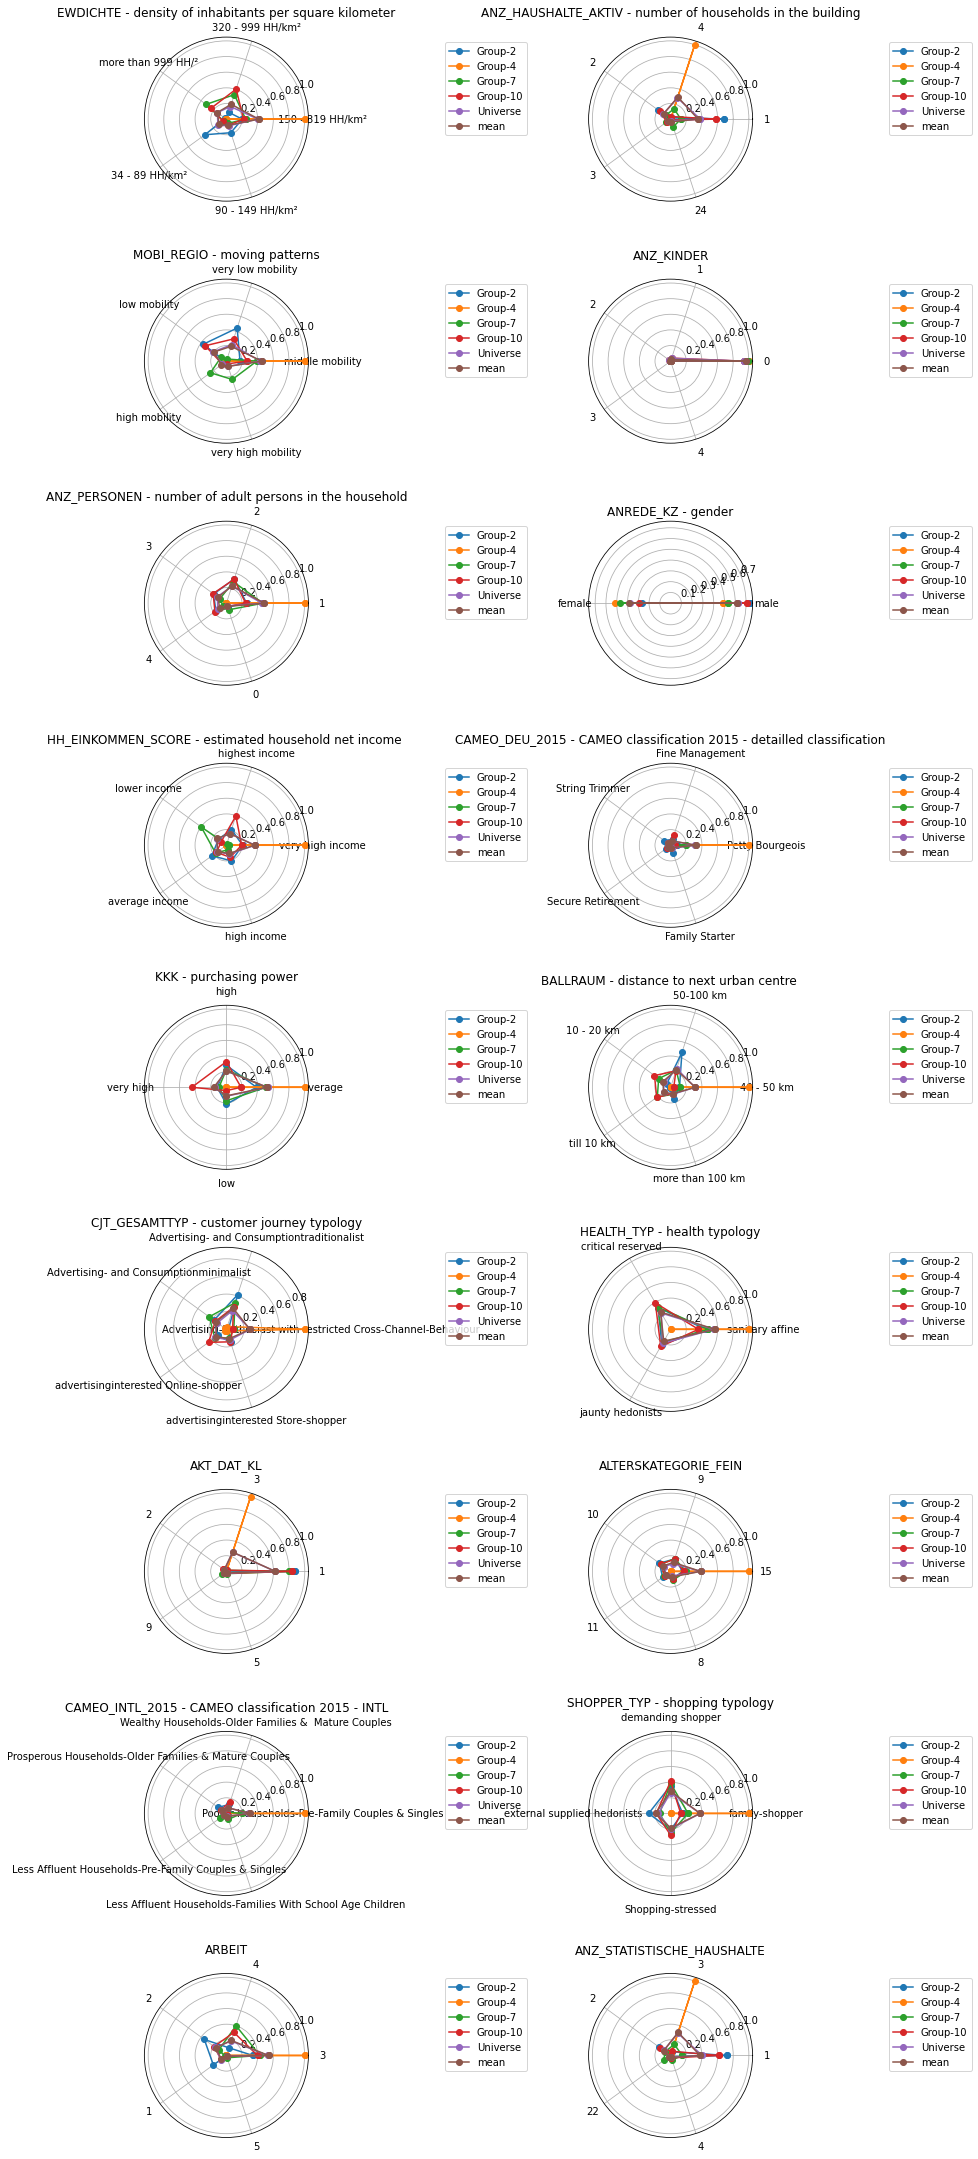

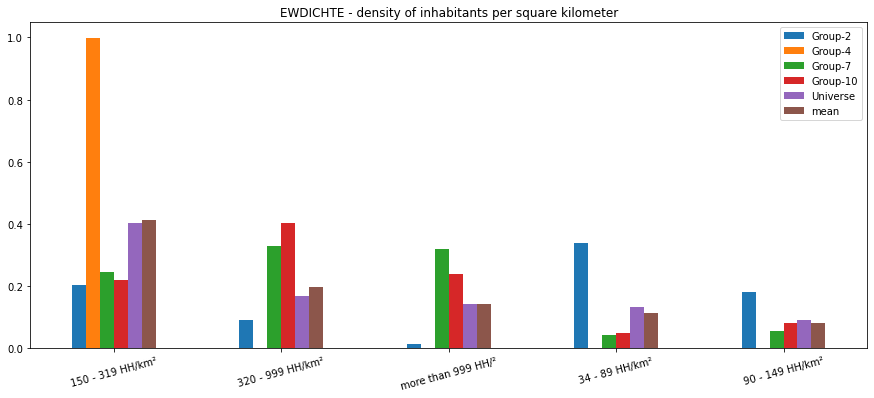

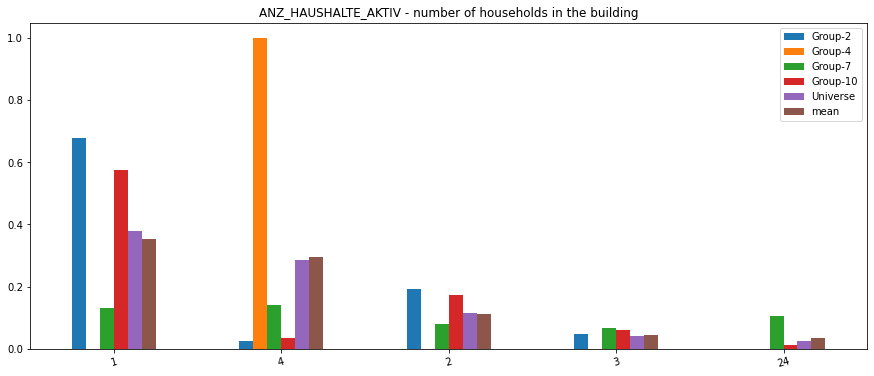

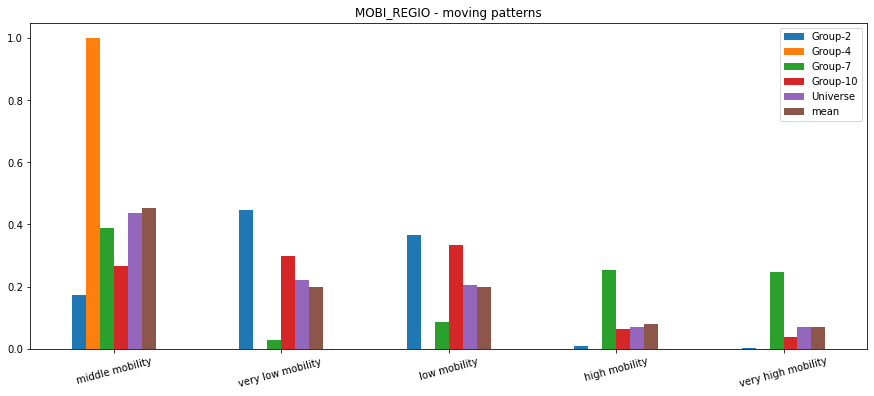

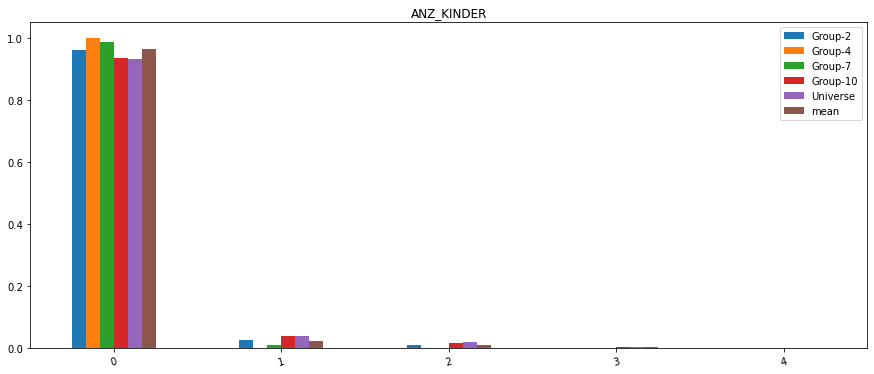

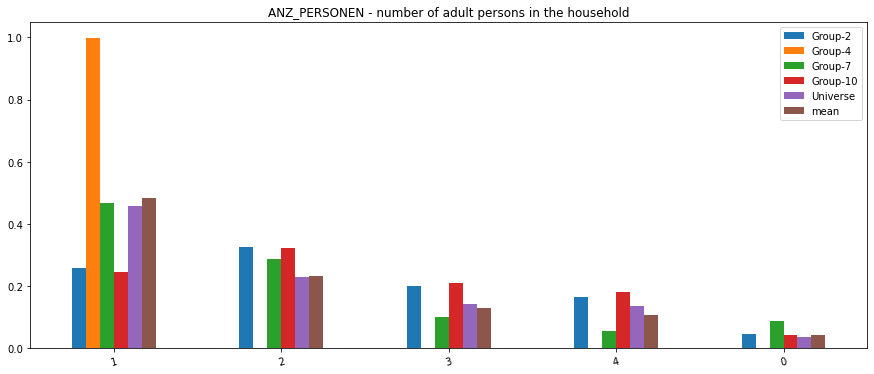

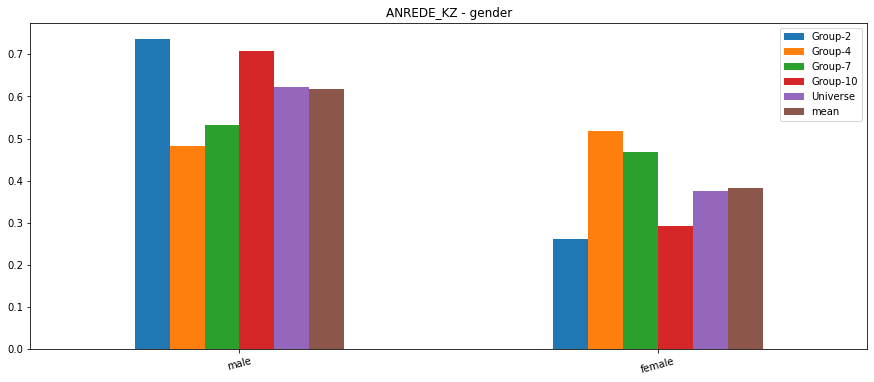

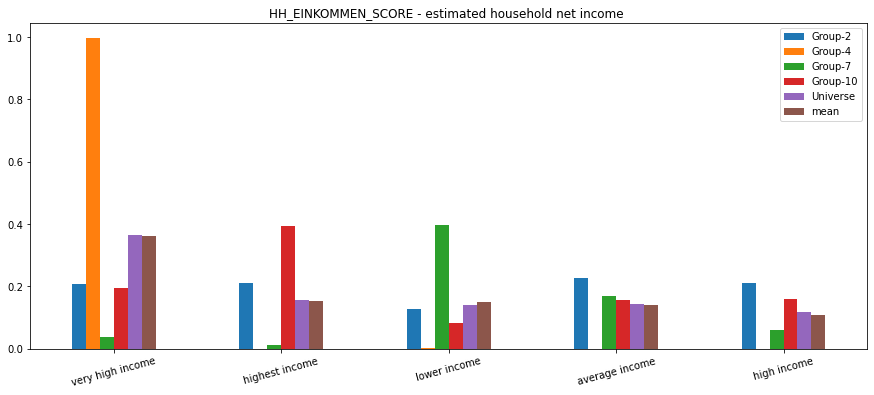

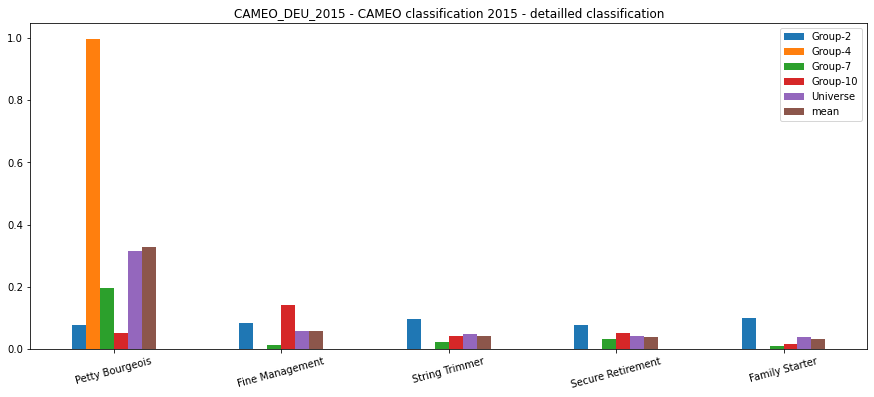

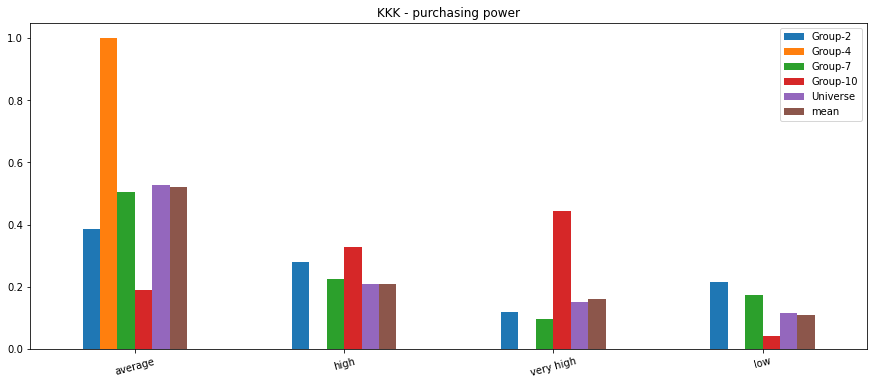

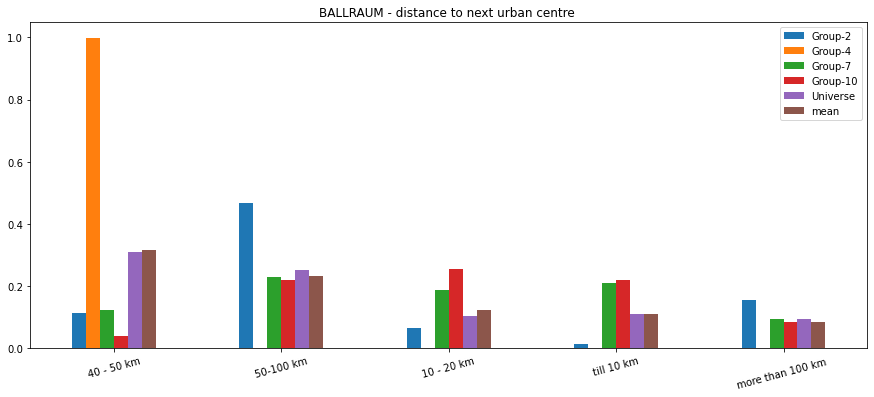

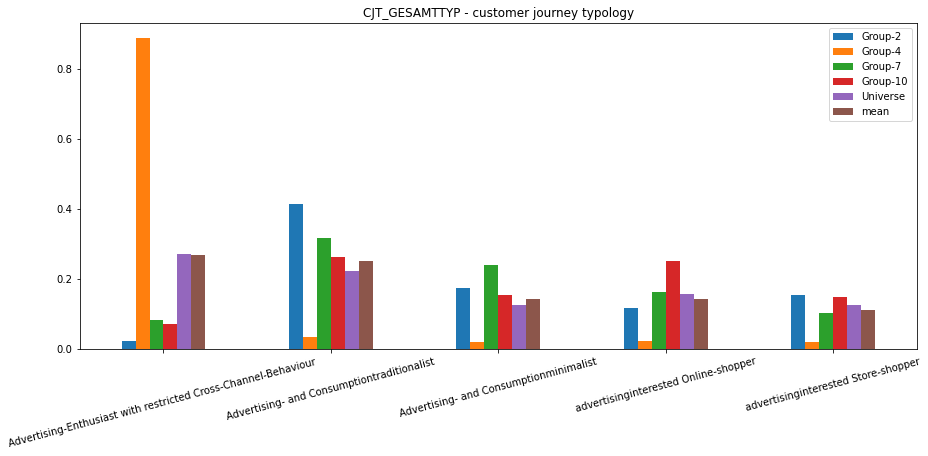

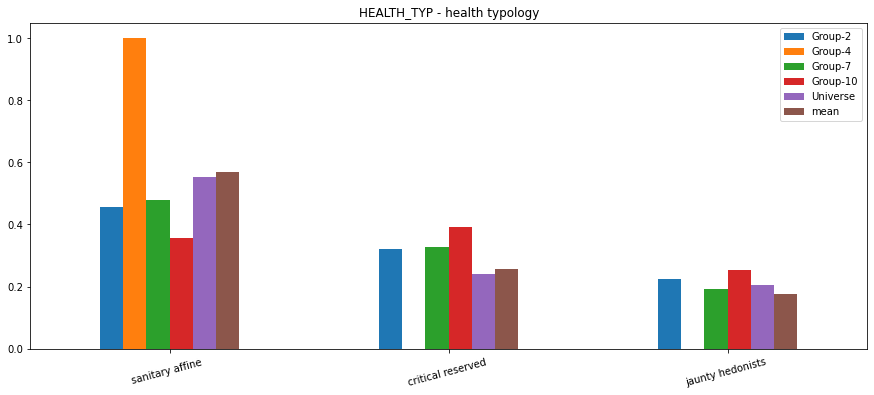

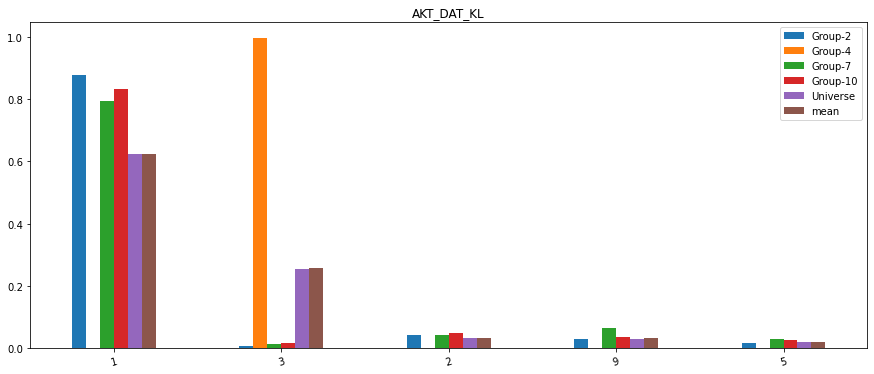

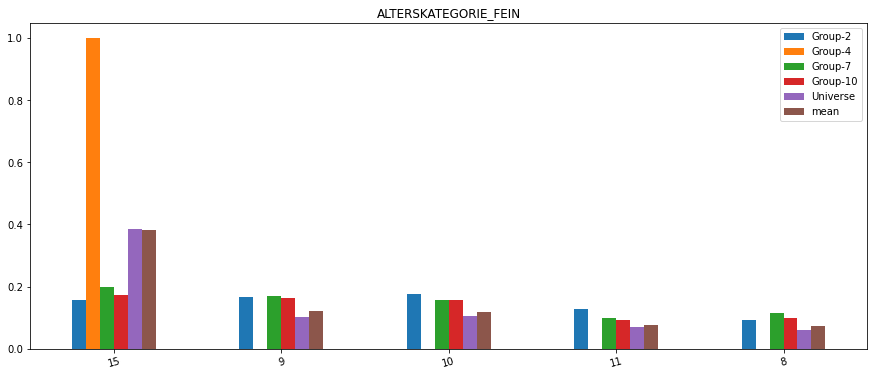

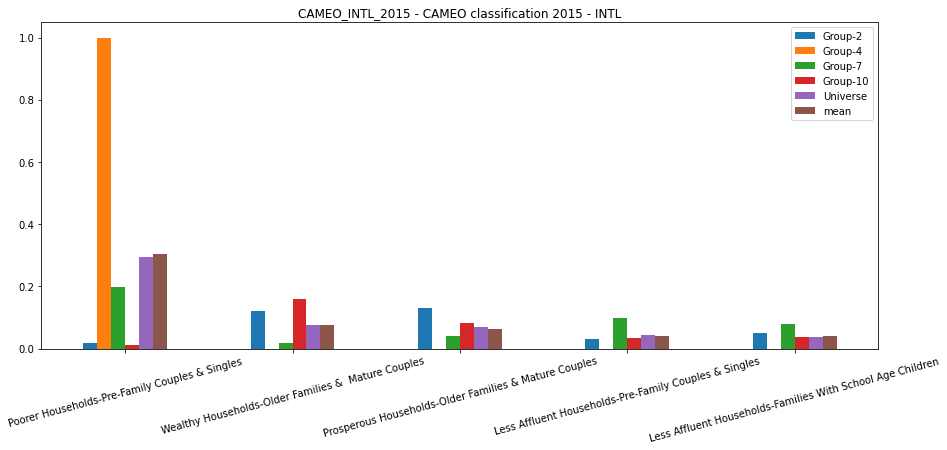

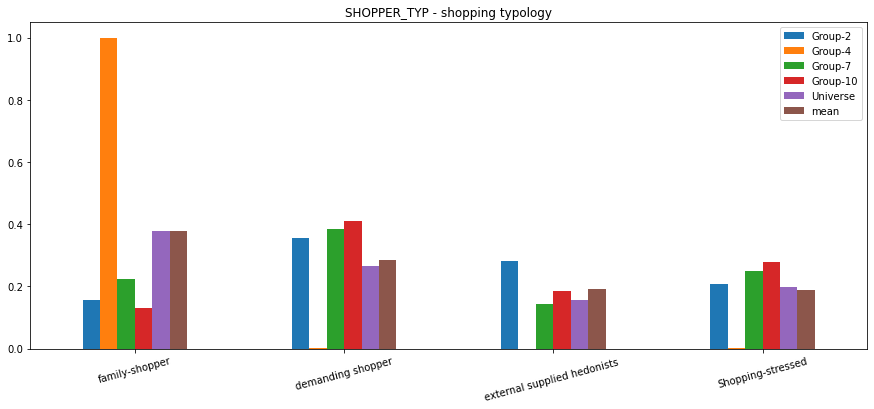

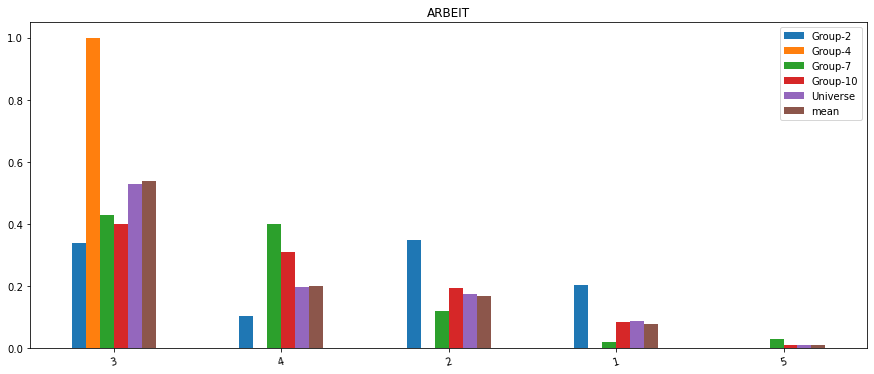

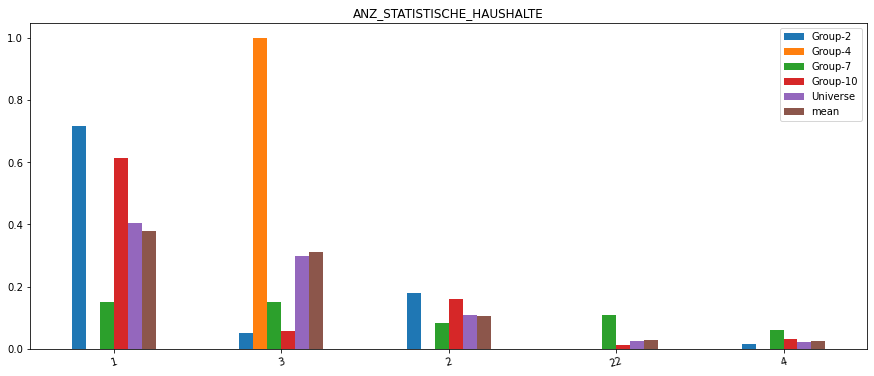

In [31]:
# Figure configuration
fig, axs = plt.subplots(9, 2, subplot_kw={'projection': 'polar'}) #constrained_layout=True,
fig.set_size_inches(15,30)
fig.tight_layout(h_pad=4)
pos_y = -1

# Plot each group's feature in a different plot to compare
for feat_no, feature in enumerate(top_features):
    # Create and merge each group to compare among the same feature
    for i, group in enumerate(top_cust_groups):
        group_df=cust_df.loc[knn[group],feature]
        temp_df=group_df.value_counts().to_frame().rename(columns={feature:'Group-'+str(group+1)})
        temp_df=temp_df/group_df.shape[0]
        if(i==0):
            compare_df=temp_df
            
        else:
            compare_df = compare_df.merge(temp_df, how='outer', left_index=True, right_index=True)
    # Add universe, all pupulation from dataset to compare.
    group_df = cust_df[feature]
    temp_df=group_df.value_counts().to_frame().rename(columns={feature:'Universe'})
    temp_df = temp_df/group_df.shape[0]
    compare_df = compare_df.merge(temp_df, how='outer', left_index=True, right_index=True)
    # Calculate mean across grups, so I can sort the highest to lowest
    compare_df['mean'] = compare_df.mean(axis=1)
    
    # Plot radar
    if(feat_no%2==0):
        pos_y=pos_y+1
    _, xlabels,plot_title=plot_radar(feature, 
                                     compare_df.sort_values('mean', ascending=False).iloc[:5,:].fillna(0), 
                                     axs[pos_y,feat_no%2])
    # Plot bar (Optionally)
    compare_df.sort_values('mean', ascending=False).iloc[:5,:].set_index(pd.Index(xlabels))\
                .plot.bar(title=plot_title, rot=15, figsize=(15,6))
    #plt.xticks(rotation=45)
plt.show()    

Interestingly one of the groups is highly narrwoed to just one of the values per classes, I suspect this could be driven by the data normalization, I will inspect the original data classes values, for this **Group-4**. Remember Kmeans clusters starts from 0, and labels from 1, therefore it corresponds to cluster number 3.

In [32]:
customers = pd.read_csv('./dataset/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

In [33]:
review_group = 3
for col in top_features:
    print(col)
    gr_tot = customers[col].count()
    nan_tot = customers[col].isna().sum()
    nan_gr_tot = customers.loc[knn[review_group], col].isna().sum()
    print('\tCustomers Total NaN:',round(nan_tot/gr_tot,2))
    print(f"\tGroup {review_group} NaNs from Total:",round(nan_gr_tot/gr_tot,2))
    print('\tCustomers over NaNs:',round(nan_gr_tot/(nan_tot+0.0001),2))

EWDICHTE
	Customers Total NaN: 0.35
	Group 3 NaNs from Total: 0.33
	Customers over NaNs: 0.93
ANZ_HAUSHALTE_AKTIV
	Customers Total NaN: 0.35
	Group 3 NaNs from Total: 0.33
	Customers over NaNs: 0.93
MOBI_REGIO
	Customers Total NaN: 0.41
	Group 3 NaNs from Total: 0.34
	Customers over NaNs: 0.83
ANZ_KINDER
	Customers Total NaN: 0.32
	Group 3 NaNs from Total: 0.32
	Customers over NaNs: 1.0
ANZ_PERSONEN
	Customers Total NaN: 0.32
	Group 3 NaNs from Total: 0.32
	Customers over NaNs: 1.0
ANREDE_KZ
	Customers Total NaN: 0.0
	Group 3 NaNs from Total: 0.0
	Customers over NaNs: 0.0
HH_EINKOMMEN_SCORE
	Customers Total NaN: 0.02
	Group 3 NaNs from Total: 0.0
	Customers over NaNs: 0.02
CAMEO_DEU_2015
	Customers Total NaN: 0.36
	Group 3 NaNs from Total: 0.33
	Customers over NaNs: 0.93
KKK
	Customers Total NaN: 0.39
	Group 3 NaNs from Total: 0.34
	Customers over NaNs: 0.86
BALLRAUM
	Customers Total NaN: 0.35
	Group 3 NaNs from Total: 0.33
	Customers over NaNs: 0.93
CJT_GESAMTTYP
	Customers Total NaN:

Most of the features with NaNs were replaced by the mean or median, and we can see how most of them (72%), were originally NaNs, and represents more than 90% of the total of NaNs. Therfore I can't use their description to give conclusions of this group, and will only consider those which have low number of NaNs in the original dataset:
- HEALTH_TYP
- ANREDE_KZ
- CJT_GESAMTTYP
- SHOPPER_TYP
- HH_EINKOMMEN_SCORE

Generally inspect most of top customer groups, highlighting those whose NaNs ratio with respect to total number of NaNs, is higher than th 10%

In [34]:
for review_group in top_cust_groups:
    print(review_group)
    for col in top_features:
        print(col)
        gr_tot = customers[col].count()
        nan_tot = customers[col].isna().sum()
        nan_gr_tot = customers.loc[knn[review_group], col].isna().sum()
        ratio = round(nan_gr_tot/(nan_tot+0.0001),3)
        if(ratio>0.1):
            print('\tCustomers Total NaN:',round(nan_tot/gr_tot,3))
            print(f"\tGroup {review_group} NaNs from Total:",round(nan_gr_tot/gr_tot,3))
            print('\tCustomers over NaNs:', ratio)

1
EWDICHTE
ANZ_HAUSHALTE_AKTIV
MOBI_REGIO
ANZ_KINDER
ANZ_PERSONEN
ANREDE_KZ
HH_EINKOMMEN_SCORE
	Customers Total NaN: 0.016
	Group 1 NaNs from Total: 0.002
	Customers over NaNs: 0.116
CAMEO_DEU_2015
KKK
BALLRAUM
CJT_GESAMTTYP
	Customers Total NaN: 0.017
	Group 1 NaNs from Total: 0.005
	Customers over NaNs: 0.282
HEALTH_TYP
AKT_DAT_KL
ALTERSKATEGORIE_FEIN
CAMEO_INTL_2015
SHOPPER_TYP
ARBEIT
ANZ_STATISTISCHE_HAUSHALTE
3
EWDICHTE
	Customers Total NaN: 0.353
	Group 3 NaNs from Total: 0.329
	Customers over NaNs: 0.934
ANZ_HAUSHALTE_AKTIV
	Customers Total NaN: 0.352
	Group 3 NaNs from Total: 0.329
	Customers over NaNs: 0.935
MOBI_REGIO
	Customers Total NaN: 0.413
	Group 3 NaNs from Total: 0.344
	Customers over NaNs: 0.834
ANZ_KINDER
	Customers Total NaN: 0.321
	Group 3 NaNs from Total: 0.321
	Customers over NaNs: 1.0
ANZ_PERSONEN
	Customers Total NaN: 0.321
	Group 3 NaNs from Total: 0.321
	Customers over NaNs: 1.0
ANREDE_KZ
HH_EINKOMMEN_SCORE
CAMEO_DEU_2015
	Customers Total NaN: 0.357
	Group 3

Besides the hilights from Group 4 (cluster 3), the only other feature that will not be considered is the feature **HH_EINKOMMEN_SCORE** for **Group-7** (Cluster 6) given that it belongs to 55% of the NaNs.

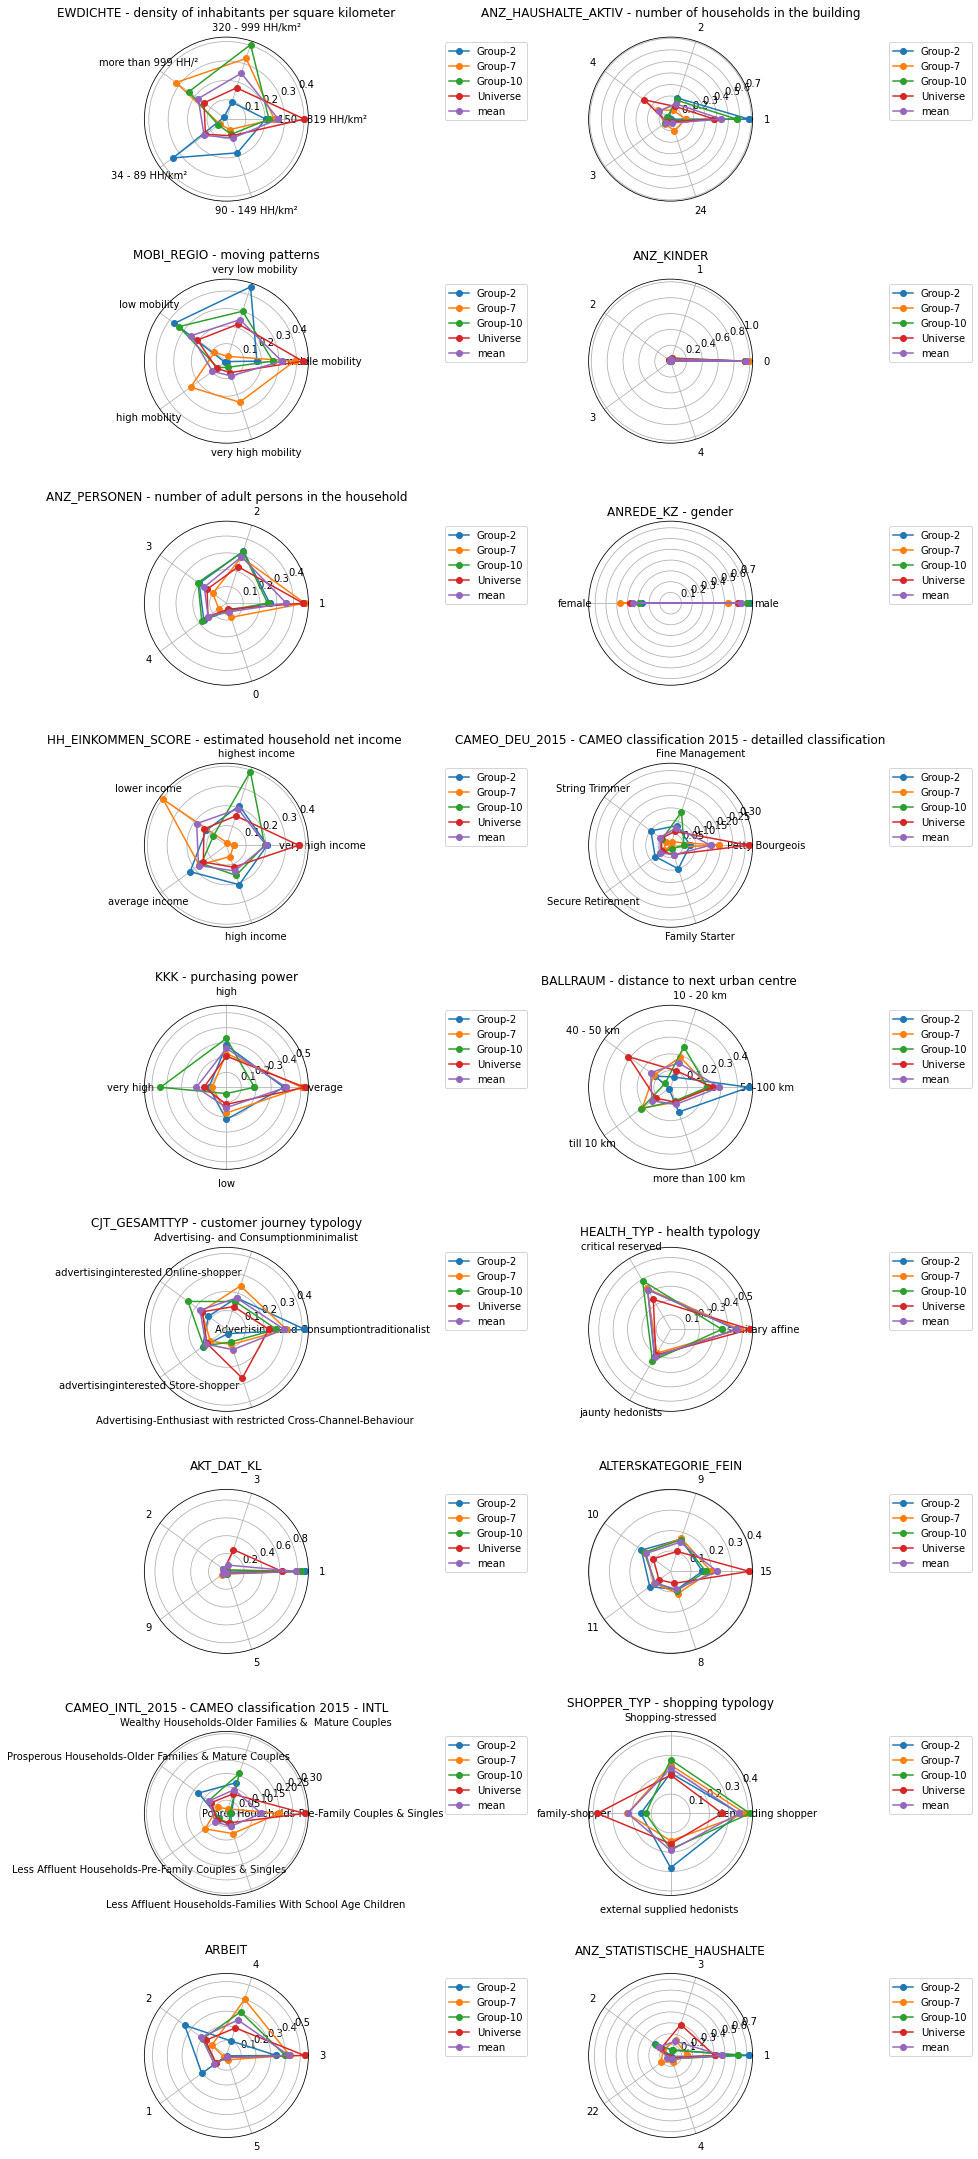

In [35]:
SKIP_GR=[3]

# Figure configuration
fig, axs = plt.subplots(9, 2, subplot_kw={'projection': 'polar'}) #constrained_layout=True,
fig.set_size_inches(15,30)
fig.tight_layout(h_pad=4)
pos_y = -1

# Plot each group's feature in a different plot to compare
for feat_no, feature in enumerate(top_features):
    # Create and merge each group to compare among the same feature
    for i, group in enumerate([gr for gr in top_cust_groups if gr not in SKIP_GR]):
        group_df=cust_df.loc[knn[group],feature]
        temp_df=group_df.value_counts().to_frame().rename(columns={feature:'Group-'+str(group+1)})
        temp_df=temp_df/group_df.shape[0]
        if(i==0):
            compare_df=temp_df
            
        else:
            compare_df = compare_df.merge(temp_df, how='outer', left_index=True, right_index=True)
    # Add universe, all pupulation from dataset to compare.
    group_df = cust_df[feature]
    temp_df=group_df.value_counts().to_frame().rename(columns={feature:'Universe'})
    temp_df = temp_df/group_df.shape[0]
    compare_df = compare_df.merge(temp_df, how='outer', left_index=True, right_index=True)
    # Calculate mean across grups, so I can sort the highest to lowest
    compare_df['mean'] = compare_df.mean(axis=1)
    
    # Plot radar
    if(feat_no%2==0):
        pos_y=pos_y+1
    _, xlabels,plot_title=plot_radar(feature, 
                                     compare_df.sort_values('mean', ascending=False).iloc[:5,:].fillna(0), 
                                     axs[pos_y,feat_no%2])
    # Plot bar (Optionally)
    #compare_df.sort_values('mean', ascending=False).iloc[:5,:].set_index(pd.Index(xlabels))\
    #            .plot.bar(title=plot_title, rot=15, figsize=(15,6))
    #plt.xticks(rotation=45)
plt.show()    

In [36]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### 2.0.0 Train Data Normalization

In [1]:
from preprocess.exploring import explore, nan_encoder
from config import config
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

Parameters of the normalazied datasets were registered and saved into a config file, in order to make it reproducible and guarantee datasets will have the same criteria for normalizing, they are retrieved under the normalize() Method.

I saved the trained estimators so I can make transformations and predictions on already trained datasets or new ones.

In [2]:
scaler, pca, kmeans = pickle.load(open('trained_models/models_clustering.pkl', 'rb'))

Let's load the raw dataset and normalize and transform it with parameters and models from previous sections.

In [3]:
%%time
# Customers
cust_groups = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
cust_normalized = explore(data='./dataset/Udacity_CUSTOMERS_052018.csv', debug=True).normalize(keep_cols = cust_groups).data
cust_transformed = pca.transform(scaler.transform(cust_normalized[config.FEATURES].astype(float)))[:,:95]
cust_kmeans = kmeans.predict(cust_transformed)

C:\Users\zeus\anaconda3\lib\site-packages\IPython\core\magic.py:187: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


DataFrame has shape: (191652, 369)
Start Normalizing
Number of columns with missinge values higher than th_na_p 0.3: 6 1.63% 
Number of rows which number of NaN columns is higher than 50: 56508 29.48%
Number of rows which all rows are NaN, from columns higher than th_na_p 0.3: 66374 34.63%
Number of numerical variables:  361
Number of discrete variables:  94
Number of continuous variables:  267
Number of categorical variables:  8
Number of columns where number of categories is higher than th_cat 45: 1
1 - Done encoding Numerical to Float
2 - Done encoding NaNs by catalog
3 - Done encoding categorical numbers to Float
4 - Done encoding categorical strings to Numbers
5 - Done replacing Outliers
6 - Done validating no NaNs
End Normalizing
Final data shape: (191652, 299)
Wall time: 14.4 s


In [4]:
%%time
# Mailout Train
train_groups = ['RESPONSE']
train_normalized = explore(data='./dataset/Udacity_MAILOUT_052018_TRAIN.csv', debug=True).normalize(keep_cols = train_groups).data
train_transformed = pca.transform(scaler.transform(train_normalized[config.FEATURES].astype(float)))[:,:95]
train_kmeans = kmeans.predict(train_transformed)

C:\Users\zeus\anaconda3\lib\site-packages\IPython\core\magic.py:187: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


DataFrame has shape: (42962, 367)
Start Normalizing
Number of columns with missinge values higher than th_na_p 0.3: 6 1.63% 
Number of rows which number of NaN columns is higher than 50: 8748 20.36%
Number of rows which all rows are NaN, from columns higher than th_na_p 0.3: 13137 30.58%
Number of numerical variables:  361
Number of discrete variables:  94
Number of continuous variables:  267
Number of categorical variables:  6
Number of columns where number of categories is higher than th_cat 45: 1
1 - Done encoding Numerical to Float
2 - Done encoding NaNs by catalog
3 - Done encoding categorical numbers to Float
4 - Done encoding categorical strings to Numbers
5 - Done replacing Outliers
6 - Done validating no NaNs
End Normalizing
Final data shape: (42962, 297)
Wall time: 3.75 s


### 2.0.1  Mail Out Train Segments distribution compared to Customers

In [5]:
# Create series of distribution of cluster among Train and Customers
cust_distribution = pd.Series(cust_kmeans).value_counts()
train_distribution = pd.Series(train_kmeans).value_counts()

Additionally, the train Mailout dataset, contains the RESPONSE of the mailout marketing campaign, we will use this grouping to find if a cluster is highlighted by this response

In [6]:
train_profile = train_normalized[train_groups].copy()
train_profile['GROUP'] = train_kmeans
train_profile.head()

,RESPONSE,GROUP
0,0.0,4
1,0.0,1
2,0.0,7
3,0.0,9
4,0.0,9


Calculate the percentage distribution of each of the previous categories, in the different clusters/groups

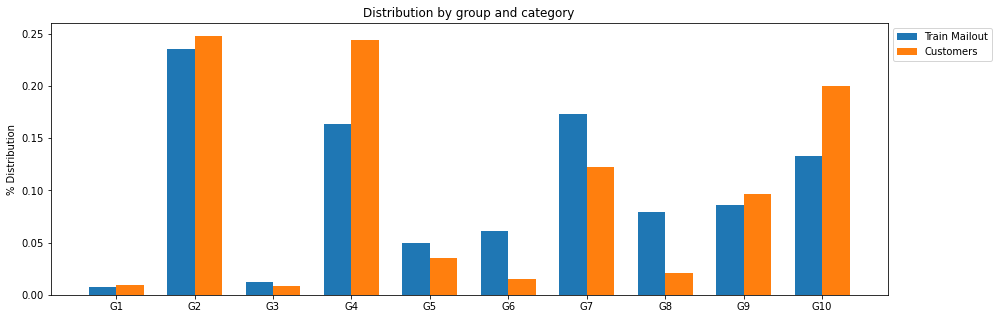

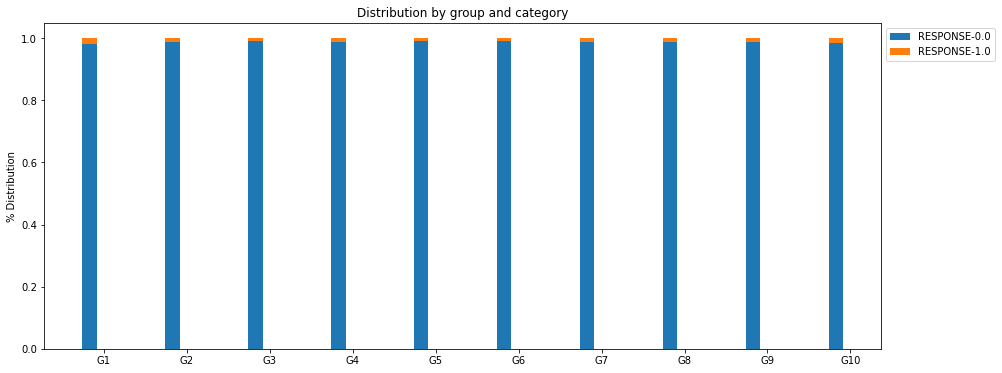

In [7]:
labels = ['G'+str(i) for i in range(1,config.N_CLUSTERS+1)]
cust_means = cust_distribution.sort_index().values/cust_distribution.sum()
train_means = train_distribution.sort_index().values/train_distribution.sum()
total_by_group = train_profile['GROUP'].value_counts().sort_index().values

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

n_1 = 2
pos_bar_idx_1 = []
for i in [width*(x+0)/(n_1-1) for x in range(n_1)]:
    pos_bar_idx_1.append(i)
n_2 = 3
pos_bar_idx_2 = []
for i in [width*(x+0)/(n_2-1) for x in range(n_2)]:
    pos_bar_idx_2.append(i)    
    
x_1 = x - width/2
x_2 = x - width/2
fig, ax = plt.subplots(figsize=(15,5))
fig2, ax2 = plt.subplots(figsize=(15,6))

rects1 = ax.bar(x_1 + pos_bar_idx_1[0], train_means, width/(n_1-1), label='Train Mailout')
rects2 = ax.bar(x_1 + pos_bar_idx_1[1], cust_means, width/(n_1-1), label='Customers')

c = []
for i, group in enumerate(train_groups):
    unique_vals = train_profile[group].unique().tolist()
    g_dist = train_profile.reset_index().groupby(['GROUP',group])['index'].count()\
                    .unstack(group).div(total_by_group, axis=0)
    bot=np.zeros(config.N_CLUSTERS)
    for unique in unique_vals:
        label=f"{group}-{unique}"
        y_vals = g_dist[unique].values#*train_means
        c.append(ax2.bar(x_2+pos_bar_idx_2[i] , y_vals, width/(n_2-1), label=label, bottom=bot)) #kind='bar', stacked=True
        bot=bot+y_vals
    #print(g_dist.to_markdown())

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% Distribution')
ax.set_title('Distribution by group and category')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1,1), loc="upper left")

ax2.set_ylabel('% Distribution')
ax2.set_title('Distribution by group and category')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend(bbox_to_anchor=(1,1), loc="upper left")

plt.show()

<AxesSubplot:>

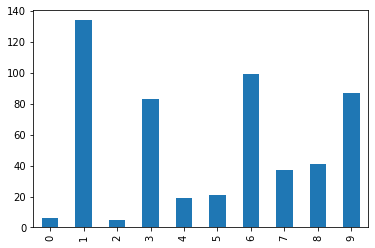

In [8]:
# Distribution of respondants 1s in the Mailout Trainging Dataset
train_profile.loc[train_profile['RESPONSE']==1.0,'GROUP'].value_counts().sort_index().plot.bar()

<AxesSubplot:>

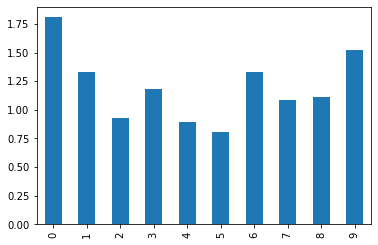

In [9]:
# Ratio of Positive Response in each group, over it's total.
(train_profile.loc[train_profile['RESPONSE']==1.0,'GROUP'].value_counts().sort_index()*100/\
 train_profile['GROUP'].value_counts().sort_index()).plot.bar()

There is less presence of Family Shoppers Traditionalists on the training mailout dataset, and slightly more in Mobile Urbans. Also there is slightly less presence on Online Shoppers.

The Weight of the positive respondants to the mailout campaign is well distributed among each of their clusters, there is no highlight in a particular Group, where there could be a noticeable higher proportion of respondants, among that group.

### Model Implementation

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score, make_scorer,balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (GradientBoostingClassifier, RandomForestClassifier,
                             ExtraTreesClassifier, AdaBoostClassifier) 
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import cross_val_score, StratifiedKFold# learning_curve
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import confusion_matrix#, auc, roc_auc_score, classification_report

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, roc_curve

import pendulum

In [6]:
SEED = 100

In [7]:
def selectEstimators():
    estimatorsCompetitors = []
    estimatorsCompetitors.append(('LogisticR', LogisticRegression(solver='liblinear', random_state=SEED)))
    estimatorsCompetitors.append(('GradientB', GradientBoostingClassifier(random_state=SEED)))
    estimatorsCompetitors.append(('RandomF', RandomForestClassifier(random_state=SEED)))
    estimatorsCompetitors.append(('ExtraTrees', ExtraTreesClassifier(random_state=SEED)))
    estimatorsCompetitors.append(('LGBM', lgb.LGBMClassifier(random_state=SEED)))
    estimatorsCompetitors.append(('XGB', xgb.XGBClassifier(random_state=SEED)))
    estimatorsCompetitors.append(('AdaB', AdaBoostClassifier(random_state=SEED)))
    estimatorsCompetitors.append(('SVC', SVC(random_state=SEED)))
    estimatorsCompetitors.append(('MLP', MLPClassifier(random_state=SEED)))
    
    return estimatorsCompetitors

In [8]:
def selectScalers():
    scalerCompetitors = []
    scalerCompetitors.append(('MinMax', MinMaxScaler()))
    scalerCompetitors.append(('Standard', StandardScaler()))
    
    return scalerCompetitors

In [9]:
def weighted_recall_score(y_true, y_pred, *, sample_weight=None, adjusted=True):
    C = confusion_matrix(y_true, y_pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        per_class = np.diag(C) / C.sum(axis=1)
    if np.any(np.isnan(per_class)):
        warnings.warn('y_pred contains classes not in y_true')
        per_class = per_class[~np.isnan(per_class)]
    score = np.mean(per_class)
    if adjusted:
        if(sample_weight==None):
            weighted = C.sum(axis=1)/C.sum()
            inv_weighted = weighted[::-1]
            weighted=weighted
        else:
            weighted = sample_weight
        score = np.dot(per_class, weighted)
    return score

def txr_score(y_true, y_pred, *, pn='P'):
    C = confusion_matrix(y_true, y_pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        per_class = np.diag(C) / C.sum(axis=1)
    if np.any(np.isnan(per_class)):
        warnings.warn('y_pred contains classes not in y_true')
        per_class = per_class[~np.isnan(per_class)]
    if(pn=='P'):
        return per_class[1]
    elif(pn=='N'):
        return per_class[0]
    else:
        warnings.err('No match for tpn, it has to be P: for TPR, or N: for TNR')

In [10]:
# Estimator extender, pass parameters and make new methods, useful for passing paramenters
class Estimator(object):
    def __init__(self, estimator, parameters=None, seed=100):
        parameters['random_state'] = seed
        self.estimator = estimator(**parameters)

    def train(self, x_train, y_train):
        self.estimator.fit(x_train, y_train)

    def predict(self, x):
        return self.estimator.predict(x)
    
    def fit(self,x,y):
        return self.estimator.fit(x,y)
    
    def feature_importances(self):
        return self.estimator.feature_importances_


In [11]:
def createPipelines(estimators, scalers):
    pipelines = []
    for scaler in scalers:
        for estimator in estimators:
            pipelines.append((f"{estimator[0]}-{scaler[0]}", Pipeline([('Scaler', scaler[1]), ('Estimator', estimator[1])])))
        
    return pipelines

In [12]:
def createScorers():
    scorers = {}
    scorers['fone_scorer']= make_scorer(fbeta_score, beta=1,average = 'weighted')
    scorers['ftwo_scorer']= make_scorer(fbeta_score, beta=2,average = 'weighted')
    scorers['ffour_scorer']= make_scorer(fbeta_score, beta=4,average = 'weighted')
    scorers['balanced_accuracy_score_scorer']= make_scorer(balanced_accuracy_score)
    scorers['weighted_scorer_3_7']= make_scorer(weighted_recall_score, sample_weight=[0.3,0.7])
    scorers['weighted_scorer_inverted']= make_scorer(weighted_recall_score)
    scorers['tpr']= make_scorer(txr_score, pn='P')
    scorers['tnr']= make_scorer(txr_score, pn='N')
    scorers['roc_auc_scorer']= make_scorer(roc_auc_score, needs_proba=False, needs_threshold=True)
    
    return scorers


In [13]:
def score(dataset, target, estimators, scorers, cv, debug=False):
    
    scores = []
    # If there is one string is single, otherwise multiple
    multiple=not(isinstance(scorers,str))
    
    for name, estimator in estimators:
        #cross_val_score cross_validate
        cv_results = cross_validate(estimator, 
                                 dataset, 
                                 target, 
                                 cv=cv, 
                                 scoring=scorers,
                                 n_jobs=-1)
        
        if(multiple):
            results={}
            for score in list(scorers.keys()):
                results[score]=cv_results['test_'+score].mean()
            scores.append((name,pd.DataFrame.from_dict(cv_results, orient='index')))
        else:
            result = cv_results['test_score'].mean()
            if(debug):
                print(f"{name}: {result}, {cv_results['test_score'].std()}")
            else:
                print('.', end='')
            scores.append((name,result))
    
    return scores
    

In [14]:
def scores_df(scores_full_feat, model_name_append=''):
    names=[]
    scalers=[]
    results=[]
    for estimator in scores_full_feat:
        es = estimator[0].split('-')
        names.append(es[0])
        scalers.append(es[1]+model_name_append)
        results.append(round(estimator[1].mean(),4))
    df = pd.DataFrame([scalers,results]).T
    df.index=names
    df.rename(columns={0:'Model', 1:'Score'}, inplace=True)
    return df

In [15]:
def save_estimator(estimator, auc_score=''):
    #If Helper Class to pass parameters was used, get estimator
    if(estimator.__class__.__name__=='Estimator'):
        estimator = estimator.estimator
    
    #Set names
    estimator_name = estimator.__class__.__name__
    datetime = pendulum.now(tz='America/Guatemala').format('YYYYMMDD_HHmm')
    
    #Save Estimator
    fname = f"trained_models/{estimator_name}{auc_score}_{datetime}.pkl"
    
    pickle.dump(estimator, open(fname, 'wb'))
    print(f"Saved model to: {fname}")
    return

def save_gsearch(gsearch):
    # Parameters
    winner_estimator = Estimator(gsearch.estimator.__class__, gsearch.best_params_)
    cv_results = pd.DataFrame.from_records(gsearch.cv_results_)
    datetime = pendulum.now(tz='America/Guatemala').format('YYYYMMDD_HHmm')
    score=f"{int(gsearch.best_score_*1000):04d}"
    estimator_name=winner_estimator.estimator.__class__.__name__
    fname=f"grid_search/{estimator_name}{score}_params_{datetime}.pipe"
    
    save_estimator(winner_estimator, score)
    cv_results.to_csv(fname, sep='|', index=False)
    print(f"Saved grid search params to: {fname}")

In [16]:
# Find high correlated features classes towards target variable Response

important_features = []
for feature in config.FEATURES:
    feat_importance = train_normalized.loc[train_normalized['RESPONSE']==1, ['RESPONSE',feature]]\
                    .groupby([feature]).count().sort_index()['RESPONSE']
    feat_distribution = train_normalized[feature].value_counts().sort_index()
    total_positive = train_normalized['RESPONSE'].sum()
    
    ratios_per_class = feat_importance/total_positive
    ratios_df = ratios_per_class.to_frame()
    ratios_df['Over Total'] = feat_importance/feat_distribution
    ratios_df['Feat Dist'] = feat_distribution/feat_distribution.sum()
    ratios_df['Feat Dist Inv'] = 1 - feat_distribution/feat_distribution.sum()
    ratios_df['Feat - Response Weight'] = ratios_df['RESPONSE']*ratios_df['Feat Dist Inv']
    ratios_df.round(2)
    
    #if((ratios_per_class > 0.6).any()):
    if((ratios_df['Feat - Response Weight'] >= 0.25).any()):
        important_features.append(feature)
        #print(ratios_df.round(4).to_markdown())
        #ratios_df.round(4).plot.bar()
        
len(important_features)        

105

In [17]:
estimators = selectEstimators()
scalers = selectScalers()
scorers = createScorers()

In [18]:
pipelines = createPipelines(estimators, scalers)

In [19]:
# Folds
skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
skf.get_n_splits(train_normalized[config.FEATURES], train_normalized['RESPONSE'].astype(int))
cv = StratifiedShuffleSplit(n_splits = 5, random_state = 10)

In [20]:
%%time
# EXAMPLE: for multiple scorers
scores = score(dataset=train_normalized[config.FEATURES], 
               target=train_normalized['RESPONSE'].astype(int),
               estimators=pipelines[:1],
               scorers=scorers,
               cv=skf,
               debug=True)
scores[0][1].head(2)

Wall time: 9.61 s


,0,1,2,3,4
fit_time,6.448447,6.884625,7.321260,6.362751,6.422734
score_time,0.149985,0.096764,0.074038,0.156996,0.126997


In [25]:
%%time
# All normalized Features
print('Features: All normalized')
scores_full_feat = score(train_normalized[config.FEATURES], 
               train_normalized['RESPONSE'].astype(int),
               pipelines[:],
               scorers='roc_auc',
               cv=skf,
               debug=False)

Features: All normalized
..................Wall time: 22min 9s


In [26]:
%%time
# Most important features related to Response var.
print('Features: Most important')
scores_top_feat = score(train_normalized[important_features], 
               train_normalized['RESPONSE'].astype(int),
               pipelines[:],
               scorers='roc_auc',
               cv=cv,
               debug=False)

Features: Most important
..................Wall time: 9min 41s


In [27]:
# Join Scores Results in a DataFrame to Display
df_sc_full = scores_df(scores_full_feat, 'FullFeat')
df_sc_imp = scores_df(scores_top_feat, 'ImportantFeat')
df_sc = pd.concat([df_sc_full, df_sc_imp], axis=1)
df_sc

,Model,Score,Model,Score
LogisticR,MinMaxFullFeat,0.6636,MinMaxImportantFeat,0.6802
GradientB,MinMaxFullFeat,0.7619,MinMaxImportantFeat,0.7661
RandomF,MinMaxFullFeat,0.6105,MinMaxImportantFeat,0.6254
ExtraTrees,MinMaxFullFeat,0.5886,MinMaxImportantFeat,0.6148
LGBM,MinMaxFullFeat,0.7208,MinMaxImportantFeat,0.7243
XGB,MinMaxFullFeat,0.6772,MinMaxImportantFeat,0.6764
AdaB,MinMaxFullFeat,0.7392,MinMaxImportantFeat,0.754
SVC,MinMaxFullFeat,0.6174,MinMaxImportantFeat,0.5955
MLP,MinMaxFullFeat,0.5942,MinMaxImportantFeat,0.6053
LogisticR,StandardFullFeat,0.6537,StandardImportantFeat,0.6753


Top estimators are **GradientBoost**, **AdaBoost** and **LGB** for Standard Scaler and using only filtered **Important Features**. I know from experience **XGB** can perform better, so I will give it a try for a GridSearch as well.

**I ran the gridSearch in aws EC2 Instances. For purposes of this notebook, I will only select two candidates close to the gird search winners I have got.**

#### XGBoost

In [21]:
estimator_xgb = xgb.XGBClassifier(random_state=SEED)

In [22]:
param_grid = {
    'objective': ['binary:logistic'],
    'eval_metric': ['logloss'],
    'n_jobs': [-1],
    'n_estimators': [105,200],
    'max_depth': [1],
    'min_samples_leaf': [0],
    'class_weight': [None],
    'use_label_encoder': [False]
}

cv = StratifiedShuffleSplit(n_splits = 5, random_state = 10)
gsearch_xgb = GridSearchCV(estimator = estimator_xgb,
                 param_grid = param_grid,
                 scoring = scorers,
                 refit = 'roc_auc_scorer',
                 cv = cv,
                 n_jobs = -1,
                 verbose = 1,
                )

In [23]:
%%time
gsearch_xgb.fit(train_normalized[important_features], 
            train_normalized['RESPONSE'].astype(int))
print(f"Best score: {gsearch_xgb.best_score_} with fallowing parameters:")
print(gsearch_xgb.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.7s finished


[15:24:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best score: 0.7833967599096615 with fallowing parameters:
{'class_weight': None, 'eval_metric': 'logloss', 'max_depth': 1, 'min_samples_leaf': 0, 'n_estimators': 105, 'n_jobs': -1, 'objective': 'binary:logistic', 'use_label_encoder': False}
Wall time: 13.9 s


In [24]:
#save_gsearch(gsearch_xgb)

In [25]:
winner_estimator = Estimator(gsearch_xgb.estimator.__class__, gsearch_xgb.best_params_)

[15:24:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




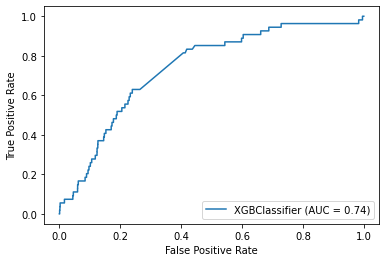

In [26]:
# Preview performance separating Train from Test
X_train, X_test, y_train, y_test = train_test_split(
                    train_normalized[config.FEATURES], train_normalized['RESPONSE'], test_size=(0.10), random_state=10)
winner_estimator.fit(X_train,y_train)
plot_roc_curve(winner_estimator.estimator, 
               X_test, 
               y_test)

#### GradientBoost

In [27]:
estimatorGB = GradientBoostingClassifier(random_state=SEED)

In [28]:
param_grid = {
    "loss":["deviance"],
    'n_estimators': [100],
    'max_depth': [3],
    "learning_rate": [0.01, 0.1],
    "max_features":[None],
    "criterion": ["friedman_mse"],
    "subsample":[1.0],
}

cv = StratifiedShuffleSplit(n_splits = 5, random_state = 10)
gsearch_gb = GridSearchCV(estimator = estimatorGB,
                 param_grid = param_grid,
                 scoring = scorers,
                 refit = 'roc_auc_scorer',
                 cv = cv,
                 n_jobs = -1,
                 verbose = 1
                )

In [29]:
%%time
gsearch_gb.fit(train_normalized[important_features], 
            train_normalized['RESPONSE'].astype(int))
print(f"Best score: {gsearch_gb.best_score_} with fallowing parameters:")
print(gsearch_gb.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   37.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   37.8s finished


Best score: 0.7783530133551474 with fallowing parameters:
{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'n_estimators': 100, 'subsample': 1.0}
Wall time: 56.3 s


In [48]:
#save_gsearch(gsearch_gb)

Saved model to: trained_models/GradientBoostingClassifier0778_20210525_1534.pkl
Saved grid search params to: grid_search/GradientBoostingClassifier0778_params_20210525_1534.pipe


In [31]:
winner_estimator = Estimator(gsearch_gb.estimator.__class__, gsearch_gb.best_params_)

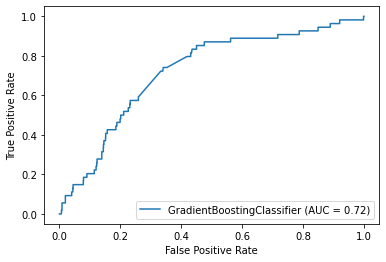

In [32]:
# Preview performance separating Train from Test
X_train, X_test, y_train, y_test = train_test_split(
                    train_normalized[config.FEATURES], train_normalized['RESPONSE'], test_size=(0.10), random_state=10)
winner_estimator.fit(X_train,y_train)
plot_roc_curve(winner_estimator.estimator, 
               X_test, 
               y_test)

#### AdaBoost

In [33]:
estimator_ada = AdaBoostClassifier(random_state=SEED)

In [39]:
param_grid = {
    'n_estimators': [102],
    "learning_rate": [0.28, 0.35],
}

cv = StratifiedShuffleSplit(n_splits = 5, random_state = 10)
gsearch_ada = GridSearchCV(estimator = estimator_ada,
                 param_grid = param_grid,
                 scoring = scorers,
                 refit = 'roc_auc_scorer',
                 cv = cv,
                 n_jobs = -1,
                 verbose = 1,
                )

In [40]:
%%time
gsearch_ada.fit(train_normalized[important_features], 
            train_normalized['RESPONSE'].astype(int))
print(f"Best score: {gsearch_ada.best_score_} with fallowing parameters:")
print(gsearch_ada.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   25.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   25.0s finished


Best score: 0.7888010598758736 with fallowing parameters:
{'learning_rate': 0.28, 'n_estimators': 102}
Wall time: 34.3 s


In [41]:
#save_gsearch(gsearch_ada)

In [42]:
winner_estimator = Estimator(gsearch_ada.estimator.__class__, gsearch_ada.best_params_)

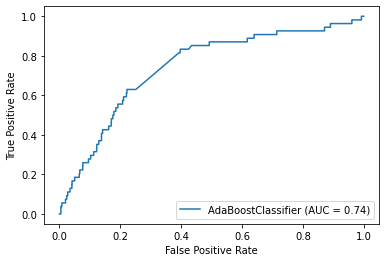

In [43]:
# Preview performance separating Train from Test
X_train, X_test, y_train, y_test = train_test_split(
                    train_normalized[config.FEATURES], train_normalized['RESPONSE'], test_size=(0.10), random_state=10)
winner_estimator.fit(X_train,y_train)
plot_roc_curve(winner_estimator.estimator, 
               X_test, 
               y_test)

#### LGB

In [44]:
estimator_lgb = lgb.LGBMClassifier(random_state=SEED)

In [45]:
param_grid = {
    'n_estimators': [125],
    "learning_rate": [0.01, 0.1],
    'min_child_samples': [25,30],
    'class_weight': [None, 'balanced'],
    'objective': ['binary']
}

cv = StratifiedShuffleSplit(n_splits = 5, random_state = 10)
gsearch_lgb = GridSearchCV(estimator = estimator_lgb,
                 param_grid = param_grid,
                 scoring = scorers,
                 refit = 'roc_auc_scorer',
                 cv = cv,
                 n_jobs = -1,
                 verbose = 1,
                )

In [46]:
%%time
gsearch_lgb.fit(train_normalized[important_features], 
            train_normalized['RESPONSE'].astype(int))
print(f"Best score: {gsearch_lgb.best_score_} with fallowing parameters:")
print(gsearch_lgb.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   36.3s finished


Best score: 0.7819007522273398 with fallowing parameters:
{'class_weight': 'balanced', 'learning_rate': 0.01, 'min_child_samples': 25, 'n_estimators': 125, 'objective': 'binary'}
Wall time: 37.6 s


In [ ]:
#save_gsearch(gsearch_lgb)

In [62]:
winner_estimator = Estimator(gsearch_lgb.estimator.__class__, gsearch_lgb.best_params_)

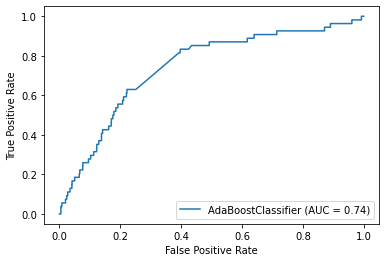

In [47]:
# Preview performance separating Train from Test
X_train, X_test, y_train, y_test = train_test_split(
                    train_normalized[config.FEATURES], train_normalized['RESPONSE'], test_size=(0.10), random_state=10)
winner_estimator.fit(X_train,y_train)
plot_roc_curve(winner_estimator.estimator, 
               X_test, 
               y_test)

### Stacking

In [49]:
# Select best models from previous Grid Search
estimators_winners = [
    ('AdaB', 'AdaBoostClassifier0788_20210524_1221.pkl'),
    ('LGB', 'LGBMClassifier0781_20210524_1159.pkl'),
    ('XGB', 'XGBClassifier0783_20210525_0042.pkl'),
    ('GB', 'GradientBoostingClassifier0778_20210525_1534.pkl')
]

In [50]:
# Build array of the estimators, to fit and test as the stacked esimator as well.
estimators = []
estimators_stacked = []
for estimator, estimator_version in estimators_winners:
    estimators.append((estimator, pickle.load(open(f"trained_models/{estimator_version}", 'rb'))))
    estimators_stacked.append((estimator, pickle.load(open(f"trained_models/{estimator_version}", 'rb'))))

C:\Users\zeus\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator AdaBoostClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [51]:
%%time
# Score winner estimators with important features selected
print('Features: Important features')
scores_full_feat = score(train_normalized[important_features], 
               train_normalized['RESPONSE'].astype(int),
               estimators,
               scorers='roc_auc',
               cv=skf,
               debug=True)

Features: Important features
AdaB: 0.7717211141543077, 0.011845672840798965
LGB: 0.7582574645646404, 0.011610259850750404
XGB: 0.7704662077255002, 0.016048529049661704
GB: 0.7661427653326174, 0.01404117378096568
Wall time: 34.5 s


In [52]:
# Fit Aall Estimators with Important Features
for estimator_name, estimator in estimators:
    print(estimator_name)
    estimator.fit(train_normalized[important_features], 
               train_normalized['RESPONSE'].astype(int))

AdaB
LGB
XGB
[15:36:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GB


In [53]:
# Predict proba for each estimator and stack them
X_stacked = {}
for estimator_name, estimator in estimators:
    print(estimator_name)
    X_stacked[estimator_name] = estimator.predict_proba(train_normalized[important_features])[:,1]

AdaB
LGB
XGB
GB


In [54]:
%%time
# Score previous models, this time as input the stacked predict proba from each model
print('Features: All normalized')
scores_full_feat = score(pd.DataFrame(X_stacked), 
               train_normalized['RESPONSE'].astype(int),
               estimators_stacked,
               scorers='roc_auc',
               cv=skf,
               debug=True)

Features: All normalized
AdaB: 0.9506705890806574, 0.004364126524629147
LGB: 0.9418154822450104, 0.008669032725378365
XGB: 0.9450806535502186, 0.0070956451910458365
GB: 0.9461844018463429, 0.007239989216378955
Wall time: 8.16 s


I suspect there is overfitting since I trained on all training Mailout dataset for the first level of estimators, and then on the second level of estimators it performs CV on the results of all trained dataset, where there could be overfitting.

I will try the stacking by separating explicityly Training from Testing, aside from CV.

#### Stacking by separating train and test

In [55]:
# Preview performance stacking models
X_train, X_test, y_train, y_test = train_test_split(
                    train_normalized[important_features], 
                    train_normalized['RESPONSE'].astype(int), 
                    test_size=(0.20), random_state=SEED)

In [94]:
# Fit Estimators with Train
for estimator_name, estimator in estimators:
    print(estimator_name)
    estimator.fit(X_train, 
               y_train)
    
# Predict proba for bot Train and Test and Stack them
X_stacked_train = {}
X_stacked_test = {}
for estimator_name, estimator in estimators:
    print(estimator_name)
    X_stacked_train[estimator_name] = estimator.predict_proba(X_train)[:,1]   
    X_stacked_test[estimator_name] = estimator.predict_proba(X_test)[:,1]
    
X_stacked_train = pd.DataFrame(X_stacked_train)
X_stacked_test = pd.DataFrame(X_stacked_test)

AdaB
LGB
XGB
[17:08:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GB
AdaB
LGB
XGB
GB


In [95]:
%%time
# Ensamble Benchmark, for train dataset (CV Score)
print('Train')
scores_full_feat = score(
               X_stacked_train, 
               y_train,
               estimators_stacked,
               scorers='roc_auc',
               cv=skf,
               debug=True)
#Overfitting suspected

Train
AdaB: 0.9557908634778907, 0.004318410617721756
LGB: 0.943127539788802, 0.007490763308223378
XGB: 0.9527192054371346, 0.004656589452215792
GB: 0.9513264612697709, 0.008760133260054743
Wall time: 9.56 s


In [96]:
print('Test')
scores_full_feat = score(
               X_stacked_test, 
               y_test,
               estimators_stacked,
               scorers='roc_auc',
               cv=skf,
               debug=True)


Test
AdaB: 0.759369631054511, 0.07514401481415799
LGB: 0.7086748645917699, 0.09568337390395709
XGB: 0.7681641744356982, 0.0714618731352206
GB: 0.7490097242744979, 0.06360732870030644


This time the Test data was not seen by the first level of estimators during training, but when performing CV, and using only test data, it will fit each iteration against its test target, and this is not desired, first I should train both first level of estimators and stacked estimators only with training data, and then predict both levels again, with testing data to evaluate performance, this way I will assure training didn't see testing data for training.

In [97]:
# Fit Estimators using training data
for estimator_name, estimator in estimators_stacked:
    print(estimator_name)
    estimator.fit(X_stacked_train, 
               y_train)

AdaB
LGB
XGB
[17:09:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GB


AdaB
LGB
XGB
GB


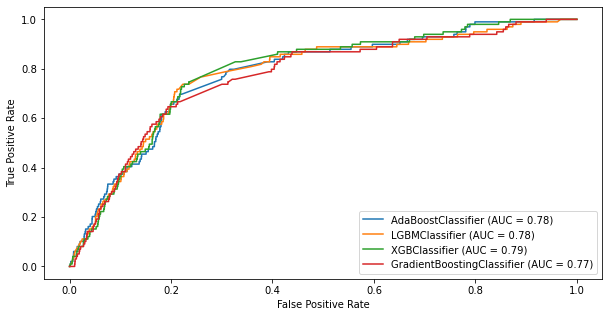

In [98]:
# Test ROC AUC for each Estimator (first level)
fig, ax = plt.subplots(figsize=(10,5))

for estimator_name, estimator in estimators:
    print(estimator_name)
    plot_roc_curve(estimator, 
           X_test, 
           y_test,
           ax=ax)

AdaB
LGB
XGB
GB


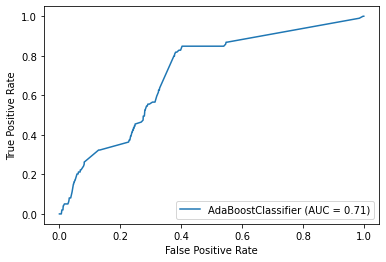

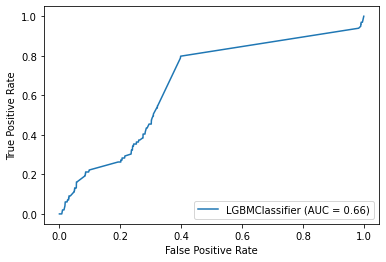

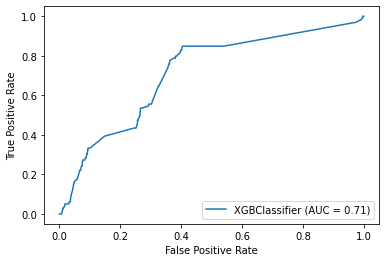

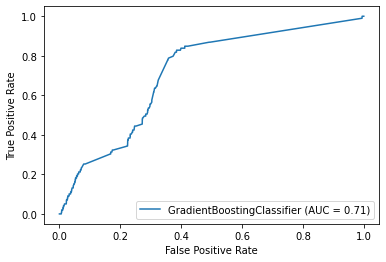

In [99]:
# Test ROC AUC for stacked Estimators
for estimator_name, estimator in estimators_stacked:
    print(estimator_name)
    plot_roc_curve(estimator, 
           pd.DataFrame(X_stacked_test), 
           y_test)

I am not very experienced in stacking estimators, it was experimental, and I get better results without stacking them, **the best estimator ROC AUC is 0.79 (XGBoost)** compared to the highest one in stacking which is 0.71 (XGBoost)

#### Training with whole Mailout Training data set, without splitting

In [85]:
xgb_fulltrain = (estimators[2][1])

In [87]:
xgb_fulltrain.fit(train_normalized[important_features], 
                train_normalized['RESPONSE'].astype(int))

[16:23:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', class_weight=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=1, min_child_weight=1,
              min_samples_leaf=0, missing=nan, monotone_constraints='()',
              n_estimators=105, n_jobs=-1, num_parallel_tree=1,
              random_state=100, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

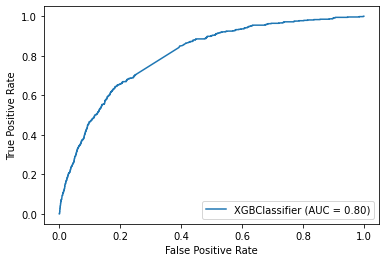

In [88]:
plot_roc_curve(xgb_fulltrain,
               train_normalized[important_features],
               train_normalized['RESPONSE'].astype(int))

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [73]:
mailout_test_lnr = pd.read_csv('./dataset/Udacity_MAILOUT_052018_TEST.csv', sep=';')['LNR']

In [74]:
%%time
# Mailout Test
test_normalized = explore(data='./dataset/Udacity_MAILOUT_052018_TEST.csv', debug=True).normalize(keep_cols = ['LNR']).data
#test_transformed = pca.transform(scaler.transform(test_normalized[config.FEATURES].astype(float)))[:,:95]
#test_kmeans = kmeans.predict(test_transformed)

C:\Users\zeus\anaconda3\lib\site-packages\IPython\core\magic.py:187: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


DataFrame has shape: (42833, 366)
Start Normalizing
Number of columns with missinge values higher than th_na_p 0.3: 6 1.64% 
Number of rows which number of NaN columns is higher than 50: 8656 20.21%
Number of rows which all rows are NaN, from columns higher than th_na_p 0.3: 12985 30.32%
Number of numerical variables:  360
Number of discrete variables:  93
Number of continuous variables:  267
Number of categorical variables:  6
Number of columns where number of categories is higher than th_cat 45: 1
1 - Done encoding Numerical to Float
2 - Done encoding NaNs by catalog
3 - Done encoding categorical numbers to Float
4 - Done encoding categorical strings to Numbers
5 - Done replacing Outliers
6 - Done validating no NaNs
End Normalizing
Final data shape: (42833, 297)
Wall time: 3.39 s


In [75]:
# Predict proba with highest estimator, in this case it was an XGboost
estimators[2]

('XGB',
 XGBClassifier(base_score=0.5, booster='gbtree', class_weight=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               eval_metric='logloss', gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.300000012,
               max_delta_step=0, max_depth=1, min_child_weight=1,
               min_samples_leaf=0, missing=nan, monotone_constraints='()',
               n_estimators=105, n_jobs=-1, num_parallel_tree=1,
               random_state=100, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               subsample=1, tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=None))

In [76]:
test_normalized[important_features].head()

,ANZ_PERSONEN,ARBEIT,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,D19_BUCH_CD,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_SOZIALES,FINANZ_ANLEGER,...,PLZ8_GBZ,RETOURTYP_BK_S,RT_SCHNAEPPCHEN,VERS_TYP,VHA,VK_ZG11,W_KEIT_KIND_HH,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,3.0,5.0,1.0,2.0,0.0,3.0,2.0,1.0,1.0,...,3.0,5.0,5.0,1.0,1.0,3.0,6.0,3.0,1.0,4.0
1,1.0,4.0,5.0,2.0,2.0,7.0,3.0,2.0,1.0,1.0,...,3.0,5.0,5.0,1.0,1.0,1.0,6.0,5.0,1.0,4.0
2,4.0,4.0,5.0,2.0,2.0,6.0,9.0,8.0,0.0,1.0,...,5.0,5.0,5.0,1.0,1.0,3.0,2.0,4.0,2.0,4.0
3,0.0,4.0,5.0,2.0,1.0,0.0,9.0,8.0,0.0,2.0,...,3.0,5.0,3.0,2.0,1.0,3.0,4.0,2.0,2.0,4.0
4,4.0,3.0,1.0,3.0,2.0,3.0,1.0,1.0,0.0,3.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,7.0,2.0,4.0


In [77]:
test_pred = (estimators[2][1]).predict_proba(test_normalized[important_features])[:,1]

#### Predict with estimator trained with complete Train dataset

In [89]:
test_pred_estFull = xgb_fulltrain.predict_proba(test_normalized[important_features])[:,1]

## Submission

In [82]:
# submission file Using Splitted Train and Test
kaggle_s = pd.DataFrame(index=mailout_test_lnr.astype('int32'), data=test_pred)
kaggle_s.rename(columns={0: "RESPONSE"}, inplace=True)
kaggle_s.to_csv('kaggle_submission/kaggle_s_20210525_1552.csv')

**Score: 0.80369**

In [90]:
# submission file Using Full Trained dataset
kaggle_s = pd.DataFrame(index=mailout_test_lnr.astype('int32'), data=test_pred_estFull)
kaggle_s.rename(columns={0: "RESPONSE"}, inplace=True)
kaggle_s.to_csv('kaggle_submission/kaggle_s_20210525_1626.csv')

**Score: 0.79644**